<a href="https://colab.research.google.com/github/HenryD1/NashNN/blob/master/Neural_Networks_for_Game_Theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch as torch
import inspect
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import types as types
from tqdm import tqdm
import collections
import copy

In [ ]:
#@title Game Solvers { display-mode: "code" }
## DESCRIPTION: THIS IS WHERE YOU PUT GAME SOLVER METHODS, INSIDE THIS CLASS

class Game: 

  
    ## DESCRIPTION OF gradDescent: VERY SHITTY METHOD, just SIMULTANOUS STEP OPTIMIZATIONS OF STRATEGIES FOR ALL PLAYERS

    ## ASSUMES ALL PLAYERS HAVE TORCH TENSORS FOR STRATEGIES
    def gradDescent(self, start_strategies, optimizers, max_epochs= 1000, noisy = False, epsilon = .1, epsilon_spread = 10):
        strategy_parameters = []
        for strategy in start_strategies:
            if torch.is_tensor(strategy):
                strategy_parameters.append([strategy])
            elif isinstance(strategy, Player):
                strategy_parameters.append(strategy.get_params())
            elif isinstance(strategy, nn.Module):
                strategy_parameters.append(strategy.parameters())
            else:
                raise Exception("One of these starting strategies was not an Class or a Tensor Yo")
        ##start_strategies must have grad enabled
        ##This is to allow you to input just one optimizer
        if not isinstance(optimizers, list):
            optimizers = [optimizers for _ in range(len(self.players))]
        ##Initialize some Optimizers
        optim = [optimizers[i](strategy_parameters[i]) for i in range(len(self.players))]

        def isolated_step(tuplet):
            ###loss, optim, param = tuplet[0], tuplet[1], tuplet[2]
            grad_ = torch.autograd.grad(tuplet[0], tuplet[2], retain_graph = True, allow_unused=True)
            back = torch.autograd.backward(tuplet[2], grad_, retain_graph = True)
            # tuplet[1].step()

        #RUn THem


        if noisy != False:
            noisy_step = [noise/max_epochs for noise in noisy]
        if epsilon != False:
            epsilon_step = epsilon/max_epochs
        for i in tqdm(range(max_epochs)):
        # for i in range(max_epochs):
            list(map(lambda x:x.zero_grad(),optim))
            # if i % 100 == 0:
            #     # print(rewards)
            #     rewards = self.play(start_strategies)
            #     (-rewards[0]).backward()
            #     print(start_strategies[0].grad)
            #     list(map(lambda x:x.zero_grad(),optim))

            if noisy == False:
                rewards = self.play(start_strategies)
            else: 
                rewards = self.noisy_play(start_strategies, epsilon, noisy, [epsilon_spread for I in range(len(start_strategies))])
            
            niosy = [noise - noise_step for noise, noise_step in zip(noisy, noisy_step)]
            epsilon = epsilon - epsilon_spread

            # print(rewards)
            loss = [-x for x in rewards]

            list(map(isolated_step, zip(loss,optim,strategy_parameters)))
            # if i % 100 == 0:
            #     print(start_strategies[0].grad)
            list(map(lambda x: x.step(), optim ))
            
            # for j in range(1):
            #     print(j)
            #     list(map(lambda x:x.zero_grad(),optim))
            #     loss = [-x for x in self.play(start_strategies)]
            #     loss[j].backward(retain_graph=True)
            #     optim[j].step()

            # for j in range(len(strategy_parameters)):
            #     list(map(lambda x:x.zero_grad(),optim))
            #     loss = [-x for x in self.play(start_strategies)]
            #     isolated_step((loss[j],optim[j],strategy_parameters[j]))
            
        return start_strategies, [-x for x in loss]

    def noisy_play(self, strats, epsilon, noise_array, epsilon_spread):
        new_strat_array = []

        class Noise_Strategy(Player):
            def __init__(self, old_strategy, noise):
                super(Noise_Strategy, self).__init__()
                self.old_strategy = old_strategy
                self.noise = noise
            def forward(self, x):
                no_noise_ans = self.old_strategy.forward(x) 
                return no_noise_ans + (torch.rand(no_noise_ans.shape) - .5) * self.noise
            def get_params(self):
                return self.old_strategy.get_params



        class Random_Strategy(Player):
            def __init__(self, old_strategy, spread):
                super(Random_Strategy, self).__init__()
                self.old_strategy = old_strategy
                self.spread = spread
            def forward(self, x):
                no_noise_ans = self.old_strategy.forward(x) 
                return (torch.rand(no_noise_ans.shape) - .5) * self.spread + (no_noise_ans - no_noise_ans)

            def get_params(self):
                return []


        for index, strategy in enumerate(strats):
            if torch.is_tensor(strategy):
                if np.random.rand() < epsilon:
                    new_strat_array.append((strategy - strategy) + (torch.rand(strategy.shape)-.5)* epsilon_spread[index])
                else:
                    new_strat_array.append(strategy + (torch.rand(strategy.shape)-.5)* noise_array[index])
            elif isinstance(strategy, Player):
                if np.random.rand() < epsilon:
                    new_strat_array.append(Random_Strategy(strategy, epsilon_spread[index]))
                else:
                    new_strat_array.append(Noise_Strategy(strategy, noise_array[index]))
            else:
                raise Exception("One of these starting strategies was not an Class or a Tensor Yo")


        
        return self.play(new_strat_array)


class Player:
    pass








In [ ]:
#@title Games { display-mode: "code" }
## MAKE NEW CLASSES HERE TO DESCRIBE NEW GAMES,, MAKE SURE EACH CLASS INHEREITS GAME

## FOR EACH NEW GAME, MUST DEFINE: 

##self.players (A LIST OF PLAYER NAMES) (THIS HASNT COME IN HANDY YET BUT MAYBE IT WILL??? IDK, SEEMED LIKE A GOOD IDEA)

##self.play (TAKE IN A LIST OF STRATEGIES, OUTPUT A LIST OF REWARDS), GOTTA KEEP EVERYTHING DIFFERENTIABLE

##self.function_players A LIST OF PLAYERS WHO HAVE STRATEGIES THAT ARE FUNCTIONS

## ADDITIONALLY IF YOU WOULD PLEASE PACK ALL INPUTS TO INIT BESIDES SELF INTO ONE LIST, THIS WOULD BE GREATLY APPRECIATED

    
class FourByFour(Game):
    
    ## DESCRIPTION: YO JUST INPUT A 3 DIMENSIONAL TENSOR INTO THIS BI*TCH, with the first axis indicating which player gets what reward, second two axes are normal ass payoff matrix, then BOOm
    def __init__(self, payoff_mat):
        self.players = ["A", "B"]
        self.payoff_mat = payoff_mat
        self.function_players = []
    def play(self, strats):
        # strats2 = [nn.functional.softmax(strat(torch.tensor([1.]))) for strat in strats]
        strats2 = [nn.functional.softmax(strat) for strat in strats]

        # strats1 = [torch.relu(strat) for strat in strats]
        # strats2 = [strat/torch.sum(strat) for strat in strats1]
        return [torch.einsum('a,ac,c->', strats2[0], self.payoff_mat[i,:,:], strats2[1]) for i in [0,1]]

class FourByFourWNet(Game):
    
    ## DESCRIPTION: YO JUST INPUT A 3 DIMENSIONAL TENSOR INTO THIS BI*TCH, with the first axis indicating which player gets what reward, second two axes are normal ass payoff matrix, then BOOm
    def __init__(self, payoff_mat):
        self.players = ["A", "B"]
        self.payoff_mat = payoff_mat
        self.function_players = []
    def play(self, strats):
        strats2 = [nn.functional.softmax(strat.forward(torch.tensor([1.]))) for strat in strats]
        # strats2 = [nn.functional.softmax(strat) for strat in strats]

        # strats1 = [torch.relu(strat) for strat in strats]
        # strats2 = [strat/torch.sum(strat) for strat in strats1]
        return [torch.einsum('a,ac,c->', strats2[0], self.payoff_mat[i,:,:], strats2[1]) for i in [0,1]]


# class PrisonersDilemma(Game):
#     def __init__(self):
#         self.players = ["A", "B"]
#         self.payoff_mat = torch.tensor([[[-8,0], [-10,-1]], [-8,-10],[0,-1]], dtype = Float) 
#         self.function_players = []
#     def play(self, strats):
#         strats = [torch.relu(strat) for strat in strats]
#         #take torch relu of what?
#         strats = [strat/torch.sum(strat) for strat in strats]
#         #this seems like some kind of renormalization given that you divide by the sum.
#         return [torch.einsum('a,ac,c->', strats[0], self.payoff_mat[i,:,:], strats[1]) for i in [0,1]] #using einstein summation because I guess thats how we're doing this




class NetworkPrincipalAgent(Game):
    def __init__(self, adj_mat):
        assert (adj_mat.shape[0] == adj_mat.shape[1] ) #this checks to see if the adjacency matrix is square.
        self.num_nodes = adj_mat.shape[0]
        for i in range(self.num_nodes):
            for j in range(self.num_nodes):
                if i <= j:
                    adj_mat[i,j] = 0
                else: 
                    if adj_mat[i,j] != 0: #ok I see. We get a matrix with inputs already. And we set all nonzero inputs to 1 to clear for training.
                        adj_mat[i,j] = 1
        self.adj_mat = adj_mat
        self.num_agents = torch.sum(self.adj_mat).type(torch.int32) #Ok got it, each one is the number of agents.
        self.players = ["principal"] + ["agent" for _ in range(self.num_agents)]

    # def transmission_prob(self, prob_nodes, prob_edges):
    #     return (1 - torch.sum(1 - (prob_nodes * prob_edges)))

    def play(self, strats):

        distribution = (torch.abs(strats[0])/torch.sum(torch.abs(strats[0])))

        # print(distribution)

        effort = []

        # for j in range(1,len(strats)):
        #     effort.append(strats[j](distribution[j].reshape((1))))

        for j in range(1,len(strats)):
            effort.append(strats[j].forward(distribution))


        strat_index = 0
        realized_adj_matrix = self.adj_mat.detach().clone()
        for i in range(self.num_nodes):
            for j in range(self.num_nodes):
                if realized_adj_matrix[i,j] == 1:
                    realized_adj_matrix[i,j] = torch.sigmoid(effort[strat_index])
                    strat_index += 1
        
        # print(realized_adj_matrix)
        
        probability_vec = torch.zeros(1)
        probability_vec[0] = 1

        for node in range(1, num_nodes):
            prob_nodes = probability_vec[:node]
            prob_edges = realized_adj_matrix[node,:node]
            # print(prob_edges)
            # probability_vec[node] = (1 - torch.prod(1 - (prob_nodes * prob_edges)))
            probability_vec = torch.cat((probability_vec, (1 - torch.prod(1 - (prob_nodes * prob_edges))).reshape((1))),0)
      
        # print(probability_vec)
        
        turnout = probability_vec[-1]

        payoffs = []


        for player in range(len(distribution)):
            payoffs.append(distribution[player] * turnout)
            if player > 0:
                payoffs[-1] = ( 2 * self.num_agents * payoffs[-1]) - torch.sigmoid(effort[player-1])
        payoffs[0] =  2 *self.num_agents * payoffs[0]
        
        return payoffs

        




class Producing_Game(Game):
    def __init__(self, params):
        self.num_workers, self.real_hour_cost, self.fake_hour_cost, self.max_hours, self.min_hours = params[0], params[1], params[2], params[3], params[4]


    def play(self, strats):
        for strat in strats[1:]:
            for element in strat:
                if element < self.min_hours:
                    element = self.min_hours
                if element > self.max_hours:
                    element = self.max_hours
        
        prod_vec = torch.zeros(num_workers)
        hour_vec = torch.zeros(num_workers)
        for worker in range(1, self.num_workers+1):
            hour_vec[worker] = torch.sum(strats[worker])
            prod_vec[worker] = strats[worker][0] 
            unprod_vec [worker] = strats[worker][1]


        distribution = params[0][1](hour_vec)
        personal_payoff = params[0][0](torch.sum(prod_vec))
        distribution = (distribution*(torch.sum(prod_vec) - personal_payoff)/(torch.sum(distribution))) - (self.real_hour_cost * prod_vec) - (self.fake_hour_cost * unprod_vec)

        payoffs = [personal_payoff]

        for i in range(distribution.shape[0]):
            payoffs.append(distribution[i])

        return payoffs


  

        


        




        



In [ ]:
#@title PD testing
class PD_Worker(Player):
    def __init__(self):
        self.mat1 = (2*torch.rand([2,1]) - 1)
        self.mat1.requires_grad = True
        self.b = (2*torch.rand([2]) - 1)
        self.b.requires_grad = True
    def get_params(self):
        return [self.mat1,self.b]

    # x represents our data
    def forward(self, x):
      output = (self.mat1 @ x) + self.b

      return output.reshape([-1])


payoff_mat = torch.tensor([[[2.,-5.],[5.,-2.]],[[2.,5.],[-5.,-2.]]])

PD = FourByFourWNet(payoff_mat)

a = PD_Worker() 
print(a.forward(torch.tensor([1.])))



# start_strats = [torch.tensor([1.,1.], requires_grad = True),torch.tensor([1.,1.], requires_grad = True)]

start_strats = [PD_Worker() for _ in range(2)] 
# torch.autograd.set_detect_anomaly(True)
Equilibrium = PD.gradDescent(start_strats, torch.optim.Adam)

print([nn.functional.softmax(eq.forward(torch.tensor([1.]))) for eq in Equilibrium[0]])
# # print([nn.functional.softmax(eq) for eq in Equilibrium[0]])


NameError: ignored

List of Solver Methods Implemented:

Chris: Shitty Naive Gradient Descent


List of Games Implemented:

Chris: Network Principal Agent Problem


In [ ]:
#@title PD testing
class PD_Worker(Player):
    def __init__(self):
      super(PD_Worker, self).__init__()
      self.fc1 = nn.Linear(1, 2)
      self.params = 

    # x represents our data
    def forward(self, x):
      output = (self.fc1(x))

      return output.reshape([-1])


payoff_mat = torch.tensor([[[2.,-5.],[5.,-2.]],[[2.,5.],[-5.,-2.]]])

PD = FourByFour(payoff_mat)

# a = PD_Worker() 
# print(a(torch.tensor([1.,1.])))



start_strats = [torch.tensor([1.,1.], requires_grad = True),torch.tensor([1.,1.], requires_grad = True)]

# start_strats = [PD_Worker() for _ in range(2)] 
torch.autograd.set_detect_anomaly(True)
Equilibrium = PD.gradDescent(start_strats, torch.optim.Adam)

# print([nn.functional.softmax(eq(torch.tensor([1.]))) for eq in Equilibrium[0]])
print([nn.functional.softmax(eq) for eq in Equilibrium[0]])


SyntaxError: ignored

In [ ]:
#@title Network_Testing_1
num_nodes = 5
adj_mat = torch.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    for j in range(i):
        adj_mat[i,j] = 1

print(adj_mat)


Network_game = NetworkPrincipalAgent(adj_mat)

num_workers = torch.sum(adj_mat).type(torch.int32)


class Network_Worker(nn.Module):
    def __init__(self):
      super(Network_Worker, self).__init__()
      self.fc1 = nn.Linear(1, 10)
      self.fc2 = nn.Linear(10, 1)

    # x represents our data
    def forward(self, x):
      x1 = torch.relu(self.fc1(x))
      output = torch.sigmoid(self.fc2(x1))

      return output


strats = [(torch.ones((num_workers + 1 )))] + [Network_Worker() for _ in range(num_workers)]
strats[0].requires_grad = True
torch.autograd.set_detect_anomaly(True)

print(Network_game.play(strats))

# Equilibrium = Network_game.gradDescent(strats, torch.optim.Adam)

# print(Equilibrium[0])

# print(Equilibrium[1])

# print(Equilibrium[1])

tensor([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.]])
[tensor(0.0857, grad_fn=<MulBackward0>), tensor([-0.5394], grad_fn=<SubBackward0>), tensor([-0.5090], grad_fn=<SubBackward0>), tensor([-0.5136], grad_fn=<SubBackward0>), tensor([-0.5536], grad_fn=<SubBackward0>), tensor([-0.5566], grad_fn=<SubBackward0>), tensor([-0.5323], grad_fn=<SubBackward0>), tensor([-0.5302], grad_fn=<SubBackward0>), tensor([-0.5537], grad_fn=<SubBackward0>), tensor([-0.5537], grad_fn=<SubBackward0>), tensor([-0.5103], grad_fn=<SubBackward0>)]


In [ ]:
num_nodes = 5
adj_mat = torch.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    for j in range(i):
        if not ((i == 4) & (j == 0)):
            adj_mat[i,j] = 1

print(adj_mat)


num_workers = torch.sum(adj_mat).type(torch.int32)


class Network_Worker(Player):
    #manually implemented optimizer, need to include
    def __init__(self):
      super(Network_Worker, self).__init__()
      self.m1 = (2*torch.rand([10,num_workers + 1]) - 1)
      self.b1 = (2*torch.rand([10]) - 1)
      self.m2 = (2*torch.rand([1,10]) - 1)
      self.b2 = (2*torch.rand([1]) - 1)

      self.m1.requires_grad = True
      self.m2.requires_grad = True
      self.b1.requires_grad = True
      self.b2.requires_grad = True

    # x represents our data
    def forward(self, x):
      x1 = torch.relu((self.m1 @ x) + self.b1)
      output = (self.m2 @ x1 + self.b2)

      return output
    def get_params(self):
        return [self.m1, self.m2, self.b1, self.b2]





Network_game = NetworkPrincipalAgent(adj_mat)


strats = [(torch.ones((num_workers + 1 )))] + [Network_Worker() for _ in range(num_workers)]
strats[0].requires_grad = True

# Network_game.play(strats)[0].backward()

# print(strats[0].grad)


# strats = [Principal()] + [Network_Worker() for _ in range(num_workers)]

torch.autograd.set_detect_anomaly(True)

# print(Network_game.play(strats))

# strats = [(torch.ones((num_workers + 1 )))] + [torch.tensor(0. ,requires_grad=True) for _ in range(num_workers)]
# strats[0].requires_grad = True

# print(Network_game.play(strats))


Equilibrium = Network_game.gradDescent(strats, torch.optim.Adam, max_epochs=130000 , epsilon = 1, noisy = [.25 for _ in range(num_workers+ 1)] )



# print(Equilibrium[1])

# print(Equilibrium[1])

  0%|          | 2/160000 [00:00<3:22:54, 13.14it/s]

tensor([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 0.]])


 92%|█████████▏| 146404/160000 [3:06:36<19:01, 11.91it/s]

Buffered data was truncated after reaching the output size limit.

In [ ]:
copyeq = copy.deepcopy(Equilibrium[0])

Equilibrium2 = Network_game.gradDescent(copyeq, torch.optim.Adam, max_epochs=100 , noisy = False )



print(Equilibrium2)

# print(Equilibrium2)

([tensor([ 8.1934, -6.3482, -6.2592, -6.5436, -6.2945, -6.4667, -6.5307, -5.2570,
        -5.9101, -6.6125, -6.2616], requires_grad=True), <__main__.Network_Worker object at 0x7fce1ec0c6a0>, <__main__.Network_Worker object at 0x7fce1ec0cda0>, <__main__.Network_Worker object at 0x7fce1ec0ccc0>, <__main__.Network_Worker object at 0x7fce1ec0cc50>, <__main__.Network_Worker object at 0x7fce1ec0cc88>, <__main__.Network_Worker object at 0x7fce1ec0cdd8>, <__main__.Network_Worker object at 0x7fce1ec0cb70>, <__main__.Network_Worker object at 0x7fce1ec0cd68>, <__main__.Network_Worker object at 0x7fce1ec0ceb8>, <__main__.Network_Worker object at 0x7fce1ec0ce48>], [tensor(0.0003, grad_fn=<NegBackward>), tensor([1.4052e-10], grad_fn=<NegBackward>), tensor([1.5342e-10], grad_fn=<NegBackward>), tensor([1.1549e-10], grad_fn=<NegBackward>), tensor([1.4757e-10], grad_fn=<NegBackward>), tensor([1.2468e-10], grad_fn=<NegBackward>), tensor([1.1645e-10], grad_fn=<NegBackward>), tensor([-1.4540e-05], grad_fn=

tensor([0.9720, 0.0053, 0.0048, 0.0020, 0.0026, 0.0024, 0.0063, 0.0012, 0.0017,
        0.0018], grad_fn=<DivBackward0>)
tensor([ 2.6555e-12,  3.6715e-11, -6.8179e-12, -3.5190e-11, -2.9191e-11,
        -1.0525e-11, -3.7650e-11,  2.9592e-11, -7.3813e-11, -4.6107e-11])


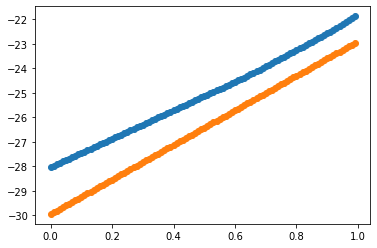

In [ ]:
print(torch.abs(Equilibrium[0][0])/torch.sum(torch.abs(Equilibrium[0][0])))
Network_game.play(Equilibrium[0])[0].backward()

print(Equilibrium[0][0].grad)

indexs = [6,7]
for index in indexs:
    firstbot = Equilibrium[0][index]


    dist = torch.abs(Equilibrium[0][0])/torch.sum(torch.abs(Equilibrium[0][0]))
    x = torch.arange(100.)/100
    y = []


    for i in range(100):
        dist2 = dist* (1 - (i / 100))/(torch.sum(dist) - dist[index])
        dist2[index] = i/100
        y.append(firstbot.forward(dist2))

    y = torch.tensor(y)

    plt.scatter(x,y)



In [ ]:

# Network_game = NetworkPrincipalAgent(adj_mat)

# print(Network_game.play(Equilibrium[0]))

# y = []
# x = torch.arange(100.) - 50 
# for i in range(len(x)):
#     new_strats = Equilibrium[0].copy()
#     class Fake_worker(nn.Module):
#         def __init__(self):
#             super(Fake_worker, self).__init__()
#         def forward(self, x):
#             return 

#     y.append(Network_game.play(new_strats))



# # plt.scatter(x,y)

yo = torch.abs(Equilibrium[0][0])/torch.sum(torch.abs(Equilibrium[0][0]))

print(yo[0])
realized_adj_matrix = Network_game.adj_mat.detach().clone()
strat_index = 1
for i in range(5):
    for j in range(i):
        if not ((i == 4) & (j == 0)):
            realized_adj_matrix[i,j] = yo[strat_index]
            strat_index += 1

print(realized_adj_matrix)


print(Equilibrium[1])
effort = []
for strat in Equilibrium[0][1:]:
    effort.append(torch.sigmoid(strat.forward(yo)))

print(effort)
strat_index = 0
for i in range(5):
    for j in range(i):
        if not ((i == 4) & (j == 0)):
            realized_adj_matrix[i,j] = effort[strat_index]
            strat_index += 1

print(realized_adj_matrix)

print(Network_game.play(Equilibrium[0]))
print(Equilibrium[1])
Network_game.play(Equilibrium[0])[0].backward()

print(Equilibrium[0][0].grad)

print(Equilibrium[0][0])


tensor(0.9720, grad_fn=<SelectBackward>)
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0053, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0048, 0.0020, 0.0000, 0.0000, 0.0000],
        [0.0026, 0.0024, 0.0063, 0.0000, 0.0000],
        [0.0000, 0.0012, 0.0017, 0.0018, 0.0000]], grad_fn=<CopySlices>)
[tensor(0., grad_fn=<NegBackward>), tensor([-2.0067e-12], grad_fn=<NegBackward>), tensor([-7.5301e-13], grad_fn=<NegBackward>), tensor([-2.2990e-13], grad_fn=<NegBackward>), tensor([-0.6289], grad_fn=<NegBackward>), tensor([-0.0727], grad_fn=<NegBackward>), tensor([-0.3568], grad_fn=<NegBackward>), tensor([-1.2314e-13], grad_fn=<NegBackward>), tensor([-2.4431e-13], grad_fn=<NegBackward>), tensor([-5.0333e-12], grad_fn=<NegBackward>)]
[tensor([1.5581e-12], grad_fn=<SigmoidBackward>), tensor([5.7750e-13], grad_fn=<SigmoidBackward>), tensor([1.7026e-13], grad_fn=<SigmoidBackward>), tensor([2.5934e-12], grad_fn=<SigmoidBackward>), tensor([4.8253e-13], grad_fn=<SigmoidBackward>), te

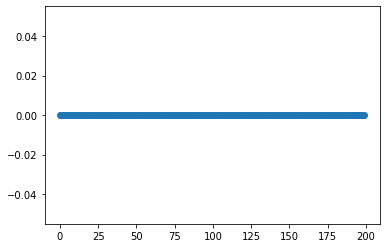

In [ ]:
strat_0 = Equilibrium[0][0]
add_vec = torch.zeros([10])
add_vec[7] = 1
x = []
y = []
for i in range(200):
    y.append(Network_game.play([strat_0 + (add_vec*(.1 * i))] + Equilibrium[0][1:])[0].item())
    x.append(i)




plt.scatter(x,y)

In [ ]:
a = -torch.ones([11]) * 100
a[7]  = 100
a[0] = 100

b = [a] + Equilibrium2[0][1:]

print(Network_game.play(b))

[tensor(10.0000, grad_fn=<MulBackward0>), tensor([-8.3302e-12], grad_fn=<SubBackward0>), tensor([-3.4962e-12], grad_fn=<SubBackward0>), tensor([-6.7280e-12], grad_fn=<SubBackward0>), tensor([-3.9421e-12], grad_fn=<SubBackward0>), tensor([-7.0066e-12], grad_fn=<SubBackward0>), tensor([-2.0462e-11], grad_fn=<SubBackward0>), tensor([9.0000], grad_fn=<SubBackward0>), tensor([-2.1119e-11], grad_fn=<SubBackward0>), tensor([-2.8034e-11], grad_fn=<SubBackward0>), tensor([-6.6097e-12], grad_fn=<SubBackward0>)]


In [ ]:
class DummyNetworkPrincipalAgent(Game):
    def __init__(self, adj_mat):
        assert (adj_mat.shape[0] == adj_mat.shape[1] ) #this checks to see if the adjacency matrix is square.
        self.num_nodes = adj_mat.shape[0]
        for i in range(self.num_nodes):
            for j in range(self.num_nodes):
                if i <= j:
                    adj_mat[i,j] = 0
                else: 
                    if adj_mat[i,j] != 0: #ok I see. We get a matrix with inputs already. And we set all nonzero inputs to 1 to clear for training.
                        adj_mat[i,j] = 1
        self.adj_mat = adj_mat
        self.num_agents = torch.sum(self.adj_mat).type(torch.int32) #Ok got it, each one is an agent.
        self.players = ["principal"]

    # def transmission_prob(self, prob_nodes, prob_edges):
    #     return (1 - torch.sum(1 - (prob_nodes * prob_edges)))

    def play(self, strats):

        distribution = nn.functional.softmax(strats[0], dim = 0)

        # print(distribution)

        effort = []

        # for j in range(1,len(strats)):
        #     effort.append(strats[j](distribution[j].reshape((1))))

        for j in range(1,len(strats)):
            effort.append(strats[j](distribution))


        strat_index = 0
        realized_adj_matrix = self.adj_mat.detach().clone()
        for i in range(self.num_nodes):
            for j in range(self.num_nodes):
                if realized_adj_matrix[i,j] == 1:
                    realized_adj_matrix[i,j] = 1
                    strat_index += 1
        
        # print(realized_adj_matrix)
        
        probability_vec = torch.zeros(1)
        probability_vec[0] = 1

        for node in range(1, num_nodes):
            prob_nodes = probability_vec[:node]
            prob_edges = realized_adj_matrix[node,:node]
            # print(prob_edges)
            # probability_vec[node] = (1 - torch.prod(1 - (prob_nodes * prob_edges)))
            probability_vec = torch.cat((probability_vec, (1 - torch.prod(1 - (prob_nodes * prob_edges))).reshape((1))),0)
      
        # print(probability_vec)
        
        turnout = probability_vec[-1]

        payoffs = []


        for player in range(1):
            payoffs.append(distribution[player] * turnout)
            if player > 0:
                payoffs[-1] = (2 * self.num_agents * payoffs[-1]) - torch.sigmoid(effort[player-1])
        payoffs[0] = 2 * self.num_agents * payoffs[0]
        
        return payoffs

num_nodes = 5
adj_mat = torch.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    for j in range(i):
        adj_mat[i,j] = 1

print(adj_mat)


num_workers = torch.sum(adj_mat).type(torch.int32)


class Network_Worker(nn.Module):
    def __init__(self):
      super(Network_Worker, self).__init__()
      self.fc1 = nn.Linear(num_workers + 1, 10)
      self.fc2 = nn.Linear(10, 1)

    # x represents our data
    def forward(self, x):
      x1 = torch.relu(self.fc1(x))
      output = (self.fc2(x1))

      return output





Network_game = DummyNetworkPrincipalAgent(adj_mat)


strats = [(torch.ones((num_workers + 1 )))] 
strats[0].requires_grad = True

# strats = [Principal()] + [Network_Worker() for _ in range(num_workers)]

torch.autograd.set_detect_anomaly(True)

# print(Network_game.play(strats))

# strats = [(torch.ones((num_workers + 1 )))] + [torch.tensor(0. ,requires_grad=True) for _ in range(num_workers)]
# strats[0].requires_grad = True

# print(Network_game.play(strats))




print(optimizer)
Equilibrium = Network_game.gradDescent(strats, torch.optim.Adam, max_epochs=10000 , noisy = [.25])


# print(Equilibrium[1])

# print(Equilibrium[1])

print(Equilibrium[0][0])
Network_game.play(Equilibrium[0])[0].backward()

Equilibrium[0][0].grad



  0%|          | 35/10000 [00:00<00:28, 345.80it/s]

tensor([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.]])
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
[tensor(1.6746, grad_fn=<MulBackward0>)]


 11%|█         | 1051/10000 [00:03<00:27, 329.56it/s]

[tensor(10.6542, grad_fn=<MulBackward0>)]


 20%|██        | 2045/10000 [00:06<00:23, 338.86it/s]

[tensor(17.3384, grad_fn=<MulBackward0>)]


 30%|███       | 3038/10000 [00:09<00:20, 334.30it/s]

[tensor(18.9485, grad_fn=<MulBackward0>)]


 40%|████      | 4034/10000 [00:12<00:17, 332.20it/s]

[tensor(19.5109, grad_fn=<MulBackward0>)]


 51%|█████     | 5054/10000 [00:15<00:14, 337.75it/s]

[tensor(19.7175, grad_fn=<MulBackward0>)]


 60%|██████    | 6047/10000 [00:18<00:11, 337.38it/s]

[tensor(19.7892, grad_fn=<MulBackward0>)]


 70%|███████   | 7045/10000 [00:21<00:08, 336.29it/s]

[tensor(0.0050, grad_fn=<MulBackward0>)]


 81%|████████  | 8068/10000 [00:24<00:05, 343.86it/s]

[tensor(19.9338, grad_fn=<MulBackward0>)]


 91%|█████████ | 9058/10000 [00:27<00:02, 325.11it/s]

[tensor(19.9613, grad_fn=<MulBackward0>)]


100%|██████████| 10000/10000 [00:30<00:00, 330.20it/s]

tensor([ 5.4948, -3.4834, -3.4836, -3.4845, -3.4848, -3.4829, -3.4830, -3.4853,
        -3.4836, -3.4840, -3.4878], requires_grad=True)


tensor([ 4.1096e-04,  1.1301e-05, -1.4041e-04,  2.9857e-04, -9.7140e-05,
        -1.6387e-04,  1.0961e-04, -5.5141e-05, -1.9469e-04, -2.0230e-04,
         2.0246e-05])

In [ ]:
print(Equilibrium[0][0])
Network_game.play(Equilibrium[0])[0].backward()

Equilibrium[0][0].grad


tensor([ 5.4948, -3.4834, -3.4836, -3.4845, -3.4848, -3.4829, -3.4830, -3.4853,
        -3.4836, -3.4840, -3.4878], requires_grad=True)


tensor([ 0.0256, -0.0025, -0.0027, -0.0022, -0.0026, -0.0027, -0.0024, -0.0026,
        -0.0027, -0.0027, -0.0025])

In [ ]:

# Network_game = NetworkPrincipalAgent(adj_mat)

# print(Network_game.play(Equilibrium[0]))

# y = []
# x = torch.arange(100.) - 50 
# for i in range(len(x)):
#     new_strats = Equilibrium[0].copy()
#     class Fake_worker(nn.Module):
#         def __init__(self):
#             super(Fake_worker, self).__init__()
#         def forward(self, x):
#             return 

#     y.append(Network_game.play(new_strats))



# # plt.scatter(x,y)

yo = nn.functional.softmax(Equilibrium[0][0], dim = 0)

print(yo[0])
realized_adj_matrix = Network_game.adj_mat.detach().clone()
strat_index = 1
for i in range(5):
    for j in range(i):
        realized_adj_matrix[i,j] = yo[strat_index]
        strat_index += 1

print(realized_adj_matrix)


print(Equilibrium[1])
effort = []
for strat in Equilibrium[0][1:]:
    effort.append(torch.sigmoid(strat(yo)))

print(effort)
strat_index = 0
for i in range(5):
    for j in range(i):
        realized_adj_matrix[i,j] = effort[strat_index]
        strat_index += 1

print(realized_adj_matrix)

print(Network_game.play(Equilibrium[0]))
print(Equilibrium[1])
Network_game.play(Equilibrium[0])[0].backward()

Equilibrium[0][0].grad

print(Equilibrium[0][0])


tensor(0.1391, grad_fn=<SelectBackward>)
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0103, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6842, 0.0149, 0.0000, 0.0000, 0.0000],
        [0.0166, 0.0165, 0.0122, 0.0000, 0.0000],
        [0.0308, 0.0106, 0.0144, 0.0505, 0.0000]], grad_fn=<CopySlices>)
[tensor(3.2457, grad_fn=<NegBackward>), tensor([0.2024], grad_fn=<NegBackward>), tensor([13.0443], grad_fn=<NegBackward>), tensor([0.3308], grad_fn=<NegBackward>), tensor([0.3174], grad_fn=<NegBackward>), tensor([0.3370], grad_fn=<NegBackward>), tensor([0.2467], grad_fn=<NegBackward>), tensor([-0.3505], grad_fn=<NegBackward>), tensor([0.2371], grad_fn=<NegBackward>), tensor([0.2847], grad_fn=<NegBackward>), tensor([0.8908], grad_fn=<NegBackward>)]
[tensor([4.7767e-12], grad_fn=<SigmoidBackward>), tensor([2.6401e-12], grad_fn=<SigmoidBackward>), tensor([1.6351e-12], grad_fn=<SigmoidBackward>), tensor([6.7436e-13], grad_fn=<SigmoidBackward>), tensor([4.1638e-13], grad_fn=<Sigmoid

In [ ]:
Equilibrium = Network_game.gradDescent(Equilibrium[0], torch.optim.Adam, max_epochs=40000 , noisy = [.25 for _ in range(num_workers+ 1)])
yo = nn.functional.softmax(Equilibrium[0][0], dim = 0)

print(yo[0])
realized_adj_matrix = Network_game.adj_mat.detach().clone()
strat_index = 1
for i in range(5):
    for j in range(i):
        realized_adj_matrix[i,j] = yo[strat_index]
        strat_index += 1

print(realized_adj_matrix)


print(Equilibrium[1])
effort = []
for strat in Equilibrium[0][1:]:
    effort.append(torch.sigmoid(strat(yo)))

print(effort)
strat_index = 0
for i in range(5):
    for j in range(i):
        realized_adj_matrix[i,j] = effort[strat_index]
        strat_index += 1

print(realized_adj_matrix)

print(Network_game.play(Equilibrium[0]))
print(Equilibrium[1])
Network_game.play(Equilibrium[0])[0].backward()

Equilibrium[0][0].grad

print(Equilibrium[0][0])

  0%|          | 2/40000 [00:00<1:16:43,  8.69it/s]

[tensor(1.5229, grad_fn=<MulBackward0>), tensor([0.0968], grad_fn=<SubBackward0>), tensor([6.5296], grad_fn=<SubBackward0>), tensor([-0.8208], grad_fn=<SubBackward0>), tensor([0.1796], grad_fn=<SubBackward0>), tensor([0.1684], grad_fn=<SubBackward0>), tensor([0.1115], grad_fn=<SubBackward0>), tensor([-0.2046], grad_fn=<SubBackward0>), tensor([0.0981], grad_fn=<SubBackward0>), tensor([-0.7383], grad_fn=<SubBackward0>), tensor([0.5321], grad_fn=<SubBackward0>)]


  3%|▎         | 1002/40000 [02:04<1:22:28,  7.88it/s]

[tensor(0.0006, grad_fn=<MulBackward0>), tensor([0.0076], grad_fn=<SubBackward0>), tensor([0.0002], grad_fn=<SubBackward0>), tensor([0.0043], grad_fn=<SubBackward0>), tensor([1.2354], grad_fn=<SubBackward0>), tensor([0.0008], grad_fn=<SubBackward0>), tensor([0.1944], grad_fn=<SubBackward0>), tensor([0.1681], grad_fn=<SubBackward0>), tensor([0.0072], grad_fn=<SubBackward0>), tensor([0.3130], grad_fn=<SubBackward0>), tensor([0.9690], grad_fn=<SubBackward0>)]


  5%|▌         | 2002/40000 [04:16<1:20:36,  7.86it/s]

[tensor(2.6305, grad_fn=<MulBackward0>), tensor([0.1931], grad_fn=<SubBackward0>), tensor([13.6439], grad_fn=<SubBackward0>), tensor([0.2885], grad_fn=<SubBackward0>), tensor([0.3214], grad_fn=<SubBackward0>), tensor([0.3661], grad_fn=<SubBackward0>), tensor([0.2387], grad_fn=<SubBackward0>), tensor([-0.4109], grad_fn=<SubBackward0>), tensor([0.2084], grad_fn=<SubBackward0>), tensor([0.2927], grad_fn=<SubBackward0>), tensor([1.1904], grad_fn=<SubBackward0>)]


  8%|▊         | 3002/40000 [06:23<1:18:27,  7.86it/s]

[tensor(2.8103, grad_fn=<MulBackward0>), tensor([0.2138], grad_fn=<SubBackward0>), tensor([13.3734], grad_fn=<SubBackward0>), tensor([0.3231], grad_fn=<SubBackward0>), tensor([0.3654], grad_fn=<SubBackward0>), tensor([0.3448], grad_fn=<SubBackward0>), tensor([0.2382], grad_fn=<SubBackward0>), tensor([-0.3800], grad_fn=<SubBackward0>), tensor([0.2004], grad_fn=<SubBackward0>), tensor([0.3260], grad_fn=<SubBackward0>), tensor([1.1659], grad_fn=<SubBackward0>)]


 10%|█         | 4002/40000 [08:28<1:22:24,  7.28it/s]

[tensor(2.7020, grad_fn=<MulBackward0>), tensor([0.1793], grad_fn=<SubBackward0>), tensor([13.8376], grad_fn=<SubBackward0>), tensor([0.3168], grad_fn=<SubBackward0>), tensor([0.2858], grad_fn=<SubBackward0>), tensor([0.3045], grad_fn=<SubBackward0>), tensor([0.2293], grad_fn=<SubBackward0>), tensor([-0.4019], grad_fn=<SubBackward0>), tensor([0.1720], grad_fn=<SubBackward0>), tensor([0.2808], grad_fn=<SubBackward0>), tensor([1.0792], grad_fn=<SubBackward0>)]


 13%|█▎        | 5002/40000 [10:36<1:10:05,  8.32it/s]

[tensor(2.9843, grad_fn=<MulBackward0>), tensor([0.2004], grad_fn=<SubBackward0>), tensor([13.2275], grad_fn=<SubBackward0>), tensor([0.2888], grad_fn=<SubBackward0>), tensor([0.3552], grad_fn=<SubBackward0>), tensor([0.4175], grad_fn=<SubBackward0>), tensor([0.2445], grad_fn=<SubBackward0>), tensor([-0.4202], grad_fn=<SubBackward0>), tensor([0.2491], grad_fn=<SubBackward0>), tensor([0.2399], grad_fn=<SubBackward0>), tensor([1.1234], grad_fn=<SubBackward0>)]


 15%|█▌        | 6002/40000 [12:47<1:12:33,  7.81it/s]

[tensor(0.0368, grad_fn=<MulBackward0>), tensor([1.0350], grad_fn=<SubBackward0>), tensor([13.9173], grad_fn=<SubBackward0>), tensor([0.0934], grad_fn=<SubBackward0>), tensor([0.2198], grad_fn=<SubBackward0>), tensor([0.0781], grad_fn=<SubBackward0>), tensor([2.3569], grad_fn=<SubBackward0>), tensor([-0.6322], grad_fn=<SubBackward0>), tensor([0.0322], grad_fn=<SubBackward0>), tensor([0.4890], grad_fn=<SubBackward0>), tensor([1.3739], grad_fn=<SubBackward0>)]


 18%|█▊        | 7002/40000 [14:56<1:09:45,  7.88it/s]

[tensor(3.1121, grad_fn=<MulBackward0>), tensor([0.2024], grad_fn=<SubBackward0>), tensor([13.2866], grad_fn=<SubBackward0>), tensor([0.2975], grad_fn=<SubBackward0>), tensor([0.2998], grad_fn=<SubBackward0>), tensor([-0.6701], grad_fn=<SubBackward0>), tensor([0.2225], grad_fn=<SubBackward0>), tensor([-0.3979], grad_fn=<SubBackward0>), tensor([0.2211], grad_fn=<SubBackward0>), tensor([0.3266], grad_fn=<SubBackward0>), tensor([1.0893], grad_fn=<SubBackward0>)]


 20%|██        | 8002/40000 [17:05<1:06:38,  8.00it/s]

[tensor(2.4584, grad_fn=<MulBackward0>), tensor([0.1889], grad_fn=<SubBackward0>), tensor([14.1645], grad_fn=<SubBackward0>), tensor([0.2903], grad_fn=<SubBackward0>), tensor([0.2778], grad_fn=<SubBackward0>), tensor([0.3051], grad_fn=<SubBackward0>), tensor([0.2150], grad_fn=<SubBackward0>), tensor([-0.4679], grad_fn=<SubBackward0>), tensor([0.1842], grad_fn=<SubBackward0>), tensor([-0.4395], grad_fn=<SubBackward0>), tensor([1.0902], grad_fn=<SubBackward0>)]


 23%|██▎       | 9002/40000 [19:11<1:05:21,  7.91it/s]

[tensor(2.6459, grad_fn=<MulBackward0>), tensor([0.2390], grad_fn=<SubBackward0>), tensor([13.6303], grad_fn=<SubBackward0>), tensor([0.3182], grad_fn=<SubBackward0>), tensor([0.3007], grad_fn=<SubBackward0>), tensor([0.3925], grad_fn=<SubBackward0>), tensor([0.2582], grad_fn=<SubBackward0>), tensor([-0.2938], grad_fn=<SubBackward0>), tensor([0.2196], grad_fn=<SubBackward0>), tensor([0.2927], grad_fn=<SubBackward0>), tensor([0.9967], grad_fn=<SubBackward0>)]


 25%|██▌       | 10002/40000 [21:30<1:06:15,  7.55it/s]

[tensor(2.8322, grad_fn=<MulBackward0>), tensor([0.2328], grad_fn=<SubBackward0>), tensor([13.4922], grad_fn=<SubBackward0>), tensor([0.2971], grad_fn=<SubBackward0>), tensor([0.3428], grad_fn=<SubBackward0>), tensor([0.3797], grad_fn=<SubBackward0>), tensor([0.2687], grad_fn=<SubBackward0>), tensor([-0.3512], grad_fn=<SubBackward0>), tensor([0.2267], grad_fn=<SubBackward0>), tensor([0.3148], grad_fn=<SubBackward0>), tensor([0.9642], grad_fn=<SubBackward0>)]


 28%|██▊       | 11001/40000 [23:41<1:02:14,  7.77it/s]

[tensor(2.6946, grad_fn=<MulBackward0>), tensor([0.2090], grad_fn=<SubBackward0>), tensor([13.4989], grad_fn=<SubBackward0>), tensor([0.3588], grad_fn=<SubBackward0>), tensor([0.3527], grad_fn=<SubBackward0>), tensor([0.3357], grad_fn=<SubBackward0>), tensor([0.2340], grad_fn=<SubBackward0>), tensor([-0.3669], grad_fn=<SubBackward0>), tensor([0.2514], grad_fn=<SubBackward0>), tensor([0.3483], grad_fn=<SubBackward0>), tensor([1.0738], grad_fn=<SubBackward0>)]


 30%|███       | 12002/40000 [25:55<59:02,  7.90it/s]

[tensor(2.6622, grad_fn=<MulBackward0>), tensor([0.2233], grad_fn=<SubBackward0>), tensor([13.8475], grad_fn=<SubBackward0>), tensor([0.2858], grad_fn=<SubBackward0>), tensor([0.3371], grad_fn=<SubBackward0>), tensor([0.3493], grad_fn=<SubBackward0>), tensor([-0.7411], grad_fn=<SubBackward0>), tensor([-0.4194], grad_fn=<SubBackward0>), tensor([0.2024], grad_fn=<SubBackward0>), tensor([0.2596], grad_fn=<SubBackward0>), tensor([0.9308], grad_fn=<SubBackward0>)]


 33%|███▎      | 13002/40000 [28:02<59:01,  7.62it/s]

[tensor(2.6234, grad_fn=<MulBackward0>), tensor([0.2362], grad_fn=<SubBackward0>), tensor([13.7023], grad_fn=<SubBackward0>), tensor([0.2646], grad_fn=<SubBackward0>), tensor([0.3164], grad_fn=<SubBackward0>), tensor([0.3807], grad_fn=<SubBackward0>), tensor([0.2353], grad_fn=<SubBackward0>), tensor([-0.2934], grad_fn=<SubBackward0>), tensor([0.2024], grad_fn=<SubBackward0>), tensor([0.2782], grad_fn=<SubBackward0>), tensor([1.0540], grad_fn=<SubBackward0>)]


 35%|███▌      | 14002/40000 [30:11<1:00:05,  7.21it/s]

[tensor(2.5973, grad_fn=<MulBackward0>), tensor([0.1946], grad_fn=<SubBackward0>), tensor([14.0978], grad_fn=<SubBackward0>), tensor([0.2911], grad_fn=<SubBackward0>), tensor([0.3287], grad_fn=<SubBackward0>), tensor([0.2794], grad_fn=<SubBackward0>), tensor([0.2218], grad_fn=<SubBackward0>), tensor([-0.4176], grad_fn=<SubBackward0>), tensor([0.1911], grad_fn=<SubBackward0>), tensor([0.2530], grad_fn=<SubBackward0>), tensor([0.0501], grad_fn=<SubBackward0>)]


 38%|███▊      | 15002/40000 [32:18<56:07,  7.42it/s]

[tensor(2.5331, grad_fn=<MulBackward0>), tensor([0.1776], grad_fn=<SubBackward0>), tensor([14.1723], grad_fn=<SubBackward0>), tensor([0.2273], grad_fn=<SubBackward0>), tensor([0.2859], grad_fn=<SubBackward0>), tensor([0.3204], grad_fn=<SubBackward0>), tensor([0.2447], grad_fn=<SubBackward0>), tensor([-0.4071], grad_fn=<SubBackward0>), tensor([0.1928], grad_fn=<SubBackward0>), tensor([0.2573], grad_fn=<SubBackward0>), tensor([0.9956], grad_fn=<SubBackward0>)]


 40%|████      | 16002/40000 [34:28<55:07,  7.26it/s]

[tensor(2.8271, grad_fn=<MulBackward0>), tensor([0.1936], grad_fn=<SubBackward0>), tensor([13.4778], grad_fn=<SubBackward0>), tensor([0.2888], grad_fn=<SubBackward0>), tensor([0.3328], grad_fn=<SubBackward0>), tensor([0.3282], grad_fn=<SubBackward0>), tensor([0.2341], grad_fn=<SubBackward0>), tensor([-0.4811], grad_fn=<SubBackward0>), tensor([0.2087], grad_fn=<SubBackward0>), tensor([0.2790], grad_fn=<SubBackward0>), tensor([1.3107], grad_fn=<SubBackward0>)]


 43%|████▎     | 17002/40000 [36:38<47:25,  8.08it/s]

[tensor(2.9253, grad_fn=<MulBackward0>), tensor([-0.3857], grad_fn=<SubBackward0>), tensor([13.1885], grad_fn=<SubBackward0>), tensor([0.2746], grad_fn=<SubBackward0>), tensor([0.3071], grad_fn=<SubBackward0>), tensor([0.3179], grad_fn=<SubBackward0>), tensor([0.2355], grad_fn=<SubBackward0>), tensor([-0.4859], grad_fn=<SubBackward0>), tensor([0.1906], grad_fn=<SubBackward0>), tensor([-0.7333], grad_fn=<SubBackward0>), tensor([1.1066], grad_fn=<SubBackward0>)]


 45%|████▌     | 18002/40000 [38:46<47:01,  7.80it/s]

[tensor(2.6288, grad_fn=<MulBackward0>), tensor([-0.6945], grad_fn=<SubBackward0>), tensor([13.7820], grad_fn=<SubBackward0>), tensor([0.2677], grad_fn=<SubBackward0>), tensor([0.3418], grad_fn=<SubBackward0>), tensor([-0.6721], grad_fn=<SubBackward0>), tensor([0.2287], grad_fn=<SubBackward0>), tensor([-0.3844], grad_fn=<SubBackward0>), tensor([0.2053], grad_fn=<SubBackward0>), tensor([0.2984], grad_fn=<SubBackward0>), tensor([1.0809], grad_fn=<SubBackward0>)]


 48%|████▊     | 19002/40000 [40:56<44:43,  7.82it/s]

[tensor(2.3641, grad_fn=<MulBackward0>), tensor([0.2319], grad_fn=<SubBackward0>), tensor([14.1251], grad_fn=<SubBackward0>), tensor([0.2821], grad_fn=<SubBackward0>), tensor([0.3542], grad_fn=<SubBackward0>), tensor([0.2701], grad_fn=<SubBackward0>), tensor([0.2149], grad_fn=<SubBackward0>), tensor([-0.4986], grad_fn=<SubBackward0>), tensor([0.1766], grad_fn=<SubBackward0>), tensor([0.2677], grad_fn=<SubBackward0>), tensor([1.2120], grad_fn=<SubBackward0>)]


 50%|█████     | 20002/40000 [43:02<41:00,  8.13it/s]

[tensor(0.8876, grad_fn=<MulBackward0>), tensor([0.1035], grad_fn=<SubBackward0>), tensor([0.0071], grad_fn=<SubBackward0>), tensor([1.5154], grad_fn=<SubBackward0>), tensor([0.0076], grad_fn=<SubBackward0>), tensor([12.5838], grad_fn=<SubBackward0>), tensor([0.0183], grad_fn=<SubBackward0>), tensor([1.8085], grad_fn=<SubBackward0>), tensor([0.1152], grad_fn=<SubBackward0>), tensor([0.6524], grad_fn=<SubBackward0>), tensor([1.2151], grad_fn=<SubBackward0>)]


 53%|█████▎    | 21002/40000 [45:12<44:38,  7.09it/s]

[tensor(2.3854, grad_fn=<MulBackward0>), tensor([0.2280], grad_fn=<SubBackward0>), tensor([13.2929], grad_fn=<SubBackward0>), tensor([0.2853], grad_fn=<SubBackward0>), tensor([0.3078], grad_fn=<SubBackward0>), tensor([-0.6945], grad_fn=<SubBackward0>), tensor([0.2568], grad_fn=<SubBackward0>), tensor([-0.4022], grad_fn=<SubBackward0>), tensor([0.2165], grad_fn=<SubBackward0>), tensor([0.2665], grad_fn=<SubBackward0>), tensor([0.4126], grad_fn=<SubBackward0>)]


 55%|█████▌    | 22002/40000 [47:20<39:05,  7.67it/s]

[tensor(2.4952, grad_fn=<MulBackward0>), tensor([0.2178], grad_fn=<SubBackward0>), tensor([14.1704], grad_fn=<SubBackward0>), tensor([0.2403], grad_fn=<SubBackward0>), tensor([0.3442], grad_fn=<SubBackward0>), tensor([0.3303], grad_fn=<SubBackward0>), tensor([0.2587], grad_fn=<SubBackward0>), tensor([-0.5251], grad_fn=<SubBackward0>), tensor([0.1997], grad_fn=<SubBackward0>), tensor([0.2500], grad_fn=<SubBackward0>), tensor([0.8795], grad_fn=<SubBackward0>)]


 58%|█████▊    | 23002/40000 [49:27<38:22,  7.38it/s]

[tensor(2.5476, grad_fn=<MulBackward0>), tensor([0.2154], grad_fn=<SubBackward0>), tensor([13.8558], grad_fn=<SubBackward0>), tensor([0.3382], grad_fn=<SubBackward0>), tensor([0.3051], grad_fn=<SubBackward0>), tensor([0.3582], grad_fn=<SubBackward0>), tensor([0.2403], grad_fn=<SubBackward0>), tensor([-0.3843], grad_fn=<SubBackward0>), tensor([0.1972], grad_fn=<SubBackward0>), tensor([0.2977], grad_fn=<SubBackward0>), tensor([1.0150], grad_fn=<SubBackward0>)]


 60%|██████    | 24002/40000 [51:34<33:12,  8.03it/s]

[tensor(2.6763, grad_fn=<MulBackward0>), tensor([0.2314], grad_fn=<SubBackward0>), tensor([13.9201], grad_fn=<SubBackward0>), tensor([0.2727], grad_fn=<SubBackward0>), tensor([0.2924], grad_fn=<SubBackward0>), tensor([0.3399], grad_fn=<SubBackward0>), tensor([0.2526], grad_fn=<SubBackward0>), tensor([-0.4693], grad_fn=<SubBackward0>), tensor([0.2090], grad_fn=<SubBackward0>), tensor([0.1155], grad_fn=<SubBackward0>), tensor([1.0098], grad_fn=<SubBackward0>)]


 63%|██████▎   | 25002/40000 [53:40<30:56,  8.08it/s]

[tensor(3.4173, grad_fn=<MulBackward0>), tensor([0.2150], grad_fn=<SubBackward0>), tensor([12.9233], grad_fn=<SubBackward0>), tensor([0.3101], grad_fn=<SubBackward0>), tensor([0.3283], grad_fn=<SubBackward0>), tensor([0.3001], grad_fn=<SubBackward0>), tensor([0.2435], grad_fn=<SubBackward0>), tensor([-0.3849], grad_fn=<SubBackward0>), tensor([0.2322], grad_fn=<SubBackward0>), tensor([0.2743], grad_fn=<SubBackward0>), tensor([1.1407], grad_fn=<SubBackward0>)]


 65%|██████▌   | 26002/40000 [55:48<28:59,  8.05it/s]

[tensor(2.3745, grad_fn=<MulBackward0>), tensor([0.2037], grad_fn=<SubBackward0>), tensor([14.2770], grad_fn=<SubBackward0>), tensor([0.2572], grad_fn=<SubBackward0>), tensor([0.2849], grad_fn=<SubBackward0>), tensor([0.2809], grad_fn=<SubBackward0>), tensor([0.2364], grad_fn=<SubBackward0>), tensor([-0.4280], grad_fn=<SubBackward0>), tensor([0.2030], grad_fn=<SubBackward0>), tensor([0.2577], grad_fn=<SubBackward0>), tensor([1.0527], grad_fn=<SubBackward0>)]


 68%|██████▊   | 27001/40000 [58:03<28:36,  7.57it/s]

[tensor(2.4976, grad_fn=<MulBackward0>), tensor([0.2532], grad_fn=<SubBackward0>), tensor([13.7836], grad_fn=<SubBackward0>), tensor([0.3076], grad_fn=<SubBackward0>), tensor([0.3163], grad_fn=<SubBackward0>), tensor([0.3512], grad_fn=<SubBackward0>), tensor([0.2711], grad_fn=<SubBackward0>), tensor([-0.3884], grad_fn=<SubBackward0>), tensor([0.2013], grad_fn=<SubBackward0>), tensor([0.2634], grad_fn=<SubBackward0>), tensor([1.1432], grad_fn=<SubBackward0>)]


 70%|███████   | 28002/40000 [1:00:14<25:15,  7.92it/s]

[tensor(2.8589, grad_fn=<MulBackward0>), tensor([0.2470], grad_fn=<SubBackward0>), tensor([13.3471], grad_fn=<SubBackward0>), tensor([0.3017], grad_fn=<SubBackward0>), tensor([0.3137], grad_fn=<SubBackward0>), tensor([0.3638], grad_fn=<SubBackward0>), tensor([0.2993], grad_fn=<SubBackward0>), tensor([-0.4547], grad_fn=<SubBackward0>), tensor([0.2180], grad_fn=<SubBackward0>), tensor([0.2847], grad_fn=<SubBackward0>), tensor([1.2205], grad_fn=<SubBackward0>)]


 73%|███████▎  | 29002/40000 [1:02:25<24:43,  7.41it/s]

[tensor(3.0761, grad_fn=<MulBackward0>), tensor([0.2179], grad_fn=<SubBackward0>), tensor([13.3772], grad_fn=<SubBackward0>), tensor([0.3225], grad_fn=<SubBackward0>), tensor([0.3560], grad_fn=<SubBackward0>), tensor([0.3374], grad_fn=<SubBackward0>), tensor([0.0659], grad_fn=<SubBackward0>), tensor([-0.4508], grad_fn=<SubBackward0>), tensor([0.2070], grad_fn=<SubBackward0>), tensor([0.2634], grad_fn=<SubBackward0>), tensor([1.0325], grad_fn=<SubBackward0>)]


 75%|███████▌  | 30002/40000 [1:04:37<21:32,  7.74it/s]

[tensor(2.9772, grad_fn=<MulBackward0>), tensor([0.2374], grad_fn=<SubBackward0>), tensor([13.6391], grad_fn=<SubBackward0>), tensor([0.2565], grad_fn=<SubBackward0>), tensor([0.2718], grad_fn=<SubBackward0>), tensor([0.3111], grad_fn=<SubBackward0>), tensor([0.2051], grad_fn=<SubBackward0>), tensor([-0.4233], grad_fn=<SubBackward0>), tensor([0.1871], grad_fn=<SubBackward0>), tensor([0.2616], grad_fn=<SubBackward0>), tensor([1.0493], grad_fn=<SubBackward0>)]


 78%|███████▊  | 31002/40000 [1:06:47<18:56,  7.92it/s]

[tensor(3.2190, grad_fn=<MulBackward0>), tensor([0.2305], grad_fn=<SubBackward0>), tensor([12.9676], grad_fn=<SubBackward0>), tensor([0.3405], grad_fn=<SubBackward0>), tensor([0.3319], grad_fn=<SubBackward0>), tensor([0.3678], grad_fn=<SubBackward0>), tensor([-0.7449], grad_fn=<SubBackward0>), tensor([-0.3385], grad_fn=<SubBackward0>), tensor([0.2186], grad_fn=<SubBackward0>), tensor([0.3124], grad_fn=<SubBackward0>), tensor([1.0847], grad_fn=<SubBackward0>)]


 80%|████████  | 32002/40000 [1:08:57<16:05,  8.28it/s]

[tensor(3.1963, grad_fn=<MulBackward0>), tensor([-0.7797], grad_fn=<SubBackward0>), tensor([13.5610], grad_fn=<SubBackward0>), tensor([-0.7007], grad_fn=<SubBackward0>), tensor([0.3152], grad_fn=<SubBackward0>), tensor([0.3143], grad_fn=<SubBackward0>), tensor([0.2277], grad_fn=<SubBackward0>), tensor([-0.5115], grad_fn=<SubBackward0>), tensor([0.2239], grad_fn=<SubBackward0>), tensor([0.3246], grad_fn=<SubBackward0>), tensor([0.8516], grad_fn=<SubBackward0>)]


 83%|████████▎ | 33002/40000 [1:11:06<15:00,  7.77it/s]

[tensor(3.4182, grad_fn=<MulBackward0>), tensor([0.2642], grad_fn=<SubBackward0>), tensor([12.8981], grad_fn=<SubBackward0>), tensor([0.2812], grad_fn=<SubBackward0>), tensor([0.3402], grad_fn=<SubBackward0>), tensor([0.3178], grad_fn=<SubBackward0>), tensor([0.2849], grad_fn=<SubBackward0>), tensor([-0.4576], grad_fn=<SubBackward0>), tensor([0.2133], grad_fn=<SubBackward0>), tensor([0.3328], grad_fn=<SubBackward0>), tensor([1.1069], grad_fn=<SubBackward0>)]


 85%|████████▌ | 34002/40000 [1:13:12<12:15,  8.15it/s]

[tensor(2.7220, grad_fn=<MulBackward0>), tensor([0.2165], grad_fn=<SubBackward0>), tensor([13.7698], grad_fn=<SubBackward0>), tensor([0.3021], grad_fn=<SubBackward0>), tensor([-0.2235], grad_fn=<SubBackward0>), tensor([0.2909], grad_fn=<SubBackward0>), tensor([0.2748], grad_fn=<SubBackward0>), tensor([-0.4838], grad_fn=<SubBackward0>), tensor([0.1179], grad_fn=<SubBackward0>), tensor([0.3034], grad_fn=<SubBackward0>), tensor([0.8518], grad_fn=<SubBackward0>)]


 88%|████████▊ | 35002/40000 [1:15:19<10:47,  7.71it/s]

[tensor(3.0486, grad_fn=<MulBackward0>), tensor([0.2865], grad_fn=<SubBackward0>), tensor([13.1332], grad_fn=<SubBackward0>), tensor([0.3099], grad_fn=<SubBackward0>), tensor([0.3790], grad_fn=<SubBackward0>), tensor([0.3225], grad_fn=<SubBackward0>), tensor([0.2967], grad_fn=<SubBackward0>), tensor([-0.4224], grad_fn=<SubBackward0>), tensor([0.2537], grad_fn=<SubBackward0>), tensor([0.3327], grad_fn=<SubBackward0>), tensor([1.0595], grad_fn=<SubBackward0>)]


 90%|█████████ | 36002/40000 [1:17:24<08:08,  8.18it/s]

[tensor(0.0825, grad_fn=<MulBackward0>), tensor([0.0072], grad_fn=<SubBackward0>), tensor([0.3692], grad_fn=<SubBackward0>), tensor([0.0080], grad_fn=<SubBackward0>), tensor([0.0091], grad_fn=<SubBackward0>), tensor([0.0082], grad_fn=<SubBackward0>), tensor([0.0063], grad_fn=<SubBackward0>), tensor([-0.0113], grad_fn=<SubBackward0>), tensor([0.0065], grad_fn=<SubBackward0>), tensor([0.0091], grad_fn=<SubBackward0>), tensor([0.0271], grad_fn=<SubBackward0>)]


 93%|█████████▎| 37002/40000 [1:19:34<06:19,  7.91it/s]

[tensor(3.0677, grad_fn=<MulBackward0>), tensor([0.2449], grad_fn=<SubBackward0>), tensor([13.5808], grad_fn=<SubBackward0>), tensor([0.3076], grad_fn=<SubBackward0>), tensor([0.3414], grad_fn=<SubBackward0>), tensor([0.3031], grad_fn=<SubBackward0>), tensor([0.2506], grad_fn=<SubBackward0>), tensor([-0.4571], grad_fn=<SubBackward0>), tensor([0.1805], grad_fn=<SubBackward0>), tensor([0.2875], grad_fn=<SubBackward0>), tensor([0.8706], grad_fn=<SubBackward0>)]


 95%|█████████▌| 38002/40000 [1:21:41<04:22,  7.60it/s]

[tensor(3.0763, grad_fn=<MulBackward0>), tensor([0.1422], grad_fn=<SubBackward0>), tensor([13.3249], grad_fn=<SubBackward0>), tensor([0.3072], grad_fn=<SubBackward0>), tensor([0.3459], grad_fn=<SubBackward0>), tensor([-0.5691], grad_fn=<SubBackward0>), tensor([0.2868], grad_fn=<SubBackward0>), tensor([-0.3970], grad_fn=<SubBackward0>), tensor([0.2027], grad_fn=<SubBackward0>), tensor([0.3102], grad_fn=<SubBackward0>), tensor([0.9682], grad_fn=<SubBackward0>)]


 98%|█████████▊| 39002/40000 [1:23:51<02:08,  7.76it/s]

[tensor(2.8685, grad_fn=<MulBackward0>), tensor([0.2204], grad_fn=<SubBackward0>), tensor([13.7337], grad_fn=<SubBackward0>), tensor([0.3076], grad_fn=<SubBackward0>), tensor([0.3463], grad_fn=<SubBackward0>), tensor([0.2916], grad_fn=<SubBackward0>), tensor([0.2265], grad_fn=<SubBackward0>), tensor([-0.3795], grad_fn=<SubBackward0>), tensor([0.2406], grad_fn=<SubBackward0>), tensor([0.3057], grad_fn=<SubBackward0>), tensor([0.8386], grad_fn=<SubBackward0>)]


100%|██████████| 40000/40000 [1:25:57<00:00,  7.76it/s]


tensor(0.1530, grad_fn=<SelectBackward>)
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0121, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6667, 0.0166, 0.0000, 0.0000, 0.0000],
        [0.0170, 0.0174, 0.0131, 0.0000, 0.0000],
        [0.0300, 0.0112, 0.0155, 0.0475, 0.0000]], grad_fn=<CopySlices>)
[tensor(0.0025, grad_fn=<NegBackward>), tensor([1.7799], grad_fn=<NegBackward>), tensor([4.9168], grad_fn=<NegBackward>), tensor([0.2758], grad_fn=<NegBackward>), tensor([0.5740], grad_fn=<NegBackward>), tensor([6.4046], grad_fn=<NegBackward>), tensor([0.0401], grad_fn=<NegBackward>), tensor([-0.9312], grad_fn=<NegBackward>), tensor([0.8099], grad_fn=<NegBackward>), tensor([5.1018], grad_fn=<NegBackward>), tensor([-0.9746], grad_fn=<NegBackward>)]
[tensor([5.6496e-13], grad_fn=<SigmoidBackward>), tensor([5.1131e-13], grad_fn=<SigmoidBackward>), tensor([3.7894e-13], grad_fn=<SigmoidBackward>), tensor([1.2289e-13], grad_fn=<SigmoidBackward>), tensor([7.4124e-14], grad_fn=<Sigmoid

In [ ]:
num_nodes = 5
adj_mat = torch.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    for j in range(i):
        adj_mat[i,j] = 1

print(adj_mat)


class Network_Worker(nn.Module):
    def __init__(self):
      super(Network_Worker, self).__init__()
      self.fc1 = nn.Linear(num_workers + 1, 10)
      self.fc2 = nn.Linear(10, 1)

    # x represents our data
    def forward(self, x):
      x1 = torch.relu(self.fc1(x))
      output = (self.fc2(x1))

      return output


Network_game = NetworkPrincipalAgent(adj_mat)

num_workers = torch.sum(adj_mat).type(torch.int32)

strats = [(torch.ones((num_workers + 1 )))] + [Network_Worker() for _ in range(num_workers)]
strats[0].requires_grad = True
torch.autograd.set_detect_anomaly(True)

# print(Network_game.play(strats))

# strats = [(torch.ones((num_workers + 1 )))] + [torch.tensor(0. ,requires_grad=True) for _ in range(num_workers)]
# strats[0].requires_grad = True

# print(Network_game.play(strats))

print(strats[2].parameters())
optimizer = torch.optim.Adam(strats[2].parameters())

print(optimizer)
Equilibrium = Network_game.gradDescent(strats, torch.optim.Adam, max_epochs=30000 , noisy = [.25 for _ in range(num_workers+ 1)])

yo = nn.functional.softmax(Equilibrium[0][0], dim = 0)
realized_adj_matrix = Network_game.adj_mat.detach().clone()
strat_index = 1
for i in range(5):
    for j in range(5):
        if realized_adj_matrix[i,j] == 1:
            realized_adj_matrix[i,j] = yo[strat_index]
            strat_index += 1

print(realized_adj_matrix)


  0%|          | 1/150000 [00:00<5:43:24,  7.28it/s]

tensor([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.]])
<generator object Module.parameters at 0x7f3339e38830>
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
[tensor(0.0776, grad_fn=<MulBackward0>), tensor([1.0349], grad_fn=<SubBackward0>), tensor([1.0834], grad_fn=<SubBackward0>), tensor([1.1718], grad_fn=<SubBackward0>), tensor([0.9227], grad_fn=<SubBackward0>), tensor([1.2156], grad_fn=<SubBackward0>), tensor([1.0347], grad_fn=<SubBackward0>), tensor([1.0363], grad_fn=<SubBackward0>), tensor([1.0626], grad_fn=<SubBackward0>), tensor([1.0742], grad_fn=<SubBackward0>), tensor([0.9855], grad_fn=<SubBackward0>)]


  1%|          | 1002/150000 [02:07<5:27:46,  7.58it/s]

[tensor(0.0220, grad_fn=<MulBackward0>), tensor([2.0083], grad_fn=<SubBackward0>), tensor([1.9858], grad_fn=<SubBackward0>), tensor([1.9030], grad_fn=<SubBackward0>), tensor([0.9366], grad_fn=<SubBackward0>), tensor([1.9059], grad_fn=<SubBackward0>), tensor([1.8967], grad_fn=<SubBackward0>), tensor([1.0445], grad_fn=<SubBackward0>), tensor([1.9200], grad_fn=<SubBackward0>), tensor([2.0371], grad_fn=<SubBackward0>), tensor([0.9533], grad_fn=<SubBackward0>)]


  1%|▏         | 2002/150000 [04:16<5:17:19,  7.77it/s]

[tensor(0.0091, grad_fn=<MulBackward0>), tensor([2.0797], grad_fn=<SubBackward0>), tensor([2.0188], grad_fn=<SubBackward0>), tensor([1.8787], grad_fn=<SubBackward0>), tensor([0.9616], grad_fn=<SubBackward0>), tensor([1.8963], grad_fn=<SubBackward0>), tensor([1.9482], grad_fn=<SubBackward0>), tensor([1.8657], grad_fn=<SubBackward0>), tensor([1.9354], grad_fn=<SubBackward0>), tensor([2.0791], grad_fn=<SubBackward0>), tensor([1.0605], grad_fn=<SubBackward0>)]


  2%|▏         | 3002/150000 [06:24<5:15:53,  7.76it/s]

[tensor(0.0046, grad_fn=<MulBackward0>), tensor([2.0851], grad_fn=<SubBackward0>), tensor([1.9999], grad_fn=<SubBackward0>), tensor([1.8275], grad_fn=<SubBackward0>), tensor([0.9471], grad_fn=<SubBackward0>), tensor([1.8572], grad_fn=<SubBackward0>), tensor([1.9589], grad_fn=<SubBackward0>), tensor([2.1773], grad_fn=<SubBackward0>), tensor([1.9107], grad_fn=<SubBackward0>), tensor([2.0600], grad_fn=<SubBackward0>), tensor([1.0693], grad_fn=<SubBackward0>)]


  3%|▎         | 4002/150000 [08:32<5:20:15,  7.60it/s]

[tensor(0.0025, grad_fn=<MulBackward0>), tensor([2.0911], grad_fn=<SubBackward0>), tensor([1.9810], grad_fn=<SubBackward0>), tensor([1.7798], grad_fn=<SubBackward0>), tensor([0.9339], grad_fn=<SubBackward0>), tensor([1.8215], grad_fn=<SubBackward0>), tensor([1.9751], grad_fn=<SubBackward0>), tensor([2.3751], grad_fn=<SubBackward0>), tensor([1.8885], grad_fn=<SubBackward0>), tensor([2.0393], grad_fn=<SubBackward0>), tensor([1.0581], grad_fn=<SubBackward0>)]


  3%|▎         | 5002/150000 [10:40<5:08:23,  7.84it/s]

[tensor(0.0015, grad_fn=<MulBackward0>), tensor([2.0954], grad_fn=<SubBackward0>), tensor([1.9580], grad_fn=<SubBackward0>), tensor([1.7284], grad_fn=<SubBackward0>), tensor([0.9184], grad_fn=<SubBackward0>), tensor([1.7826], grad_fn=<SubBackward0>), tensor([1.9932], grad_fn=<SubBackward0>), tensor([2.5763], grad_fn=<SubBackward0>), tensor([1.8635], grad_fn=<SubBackward0>), tensor([2.0137], grad_fn=<SubBackward0>), tensor([1.0384], grad_fn=<SubBackward0>)]


  4%|▍         | 6002/150000 [12:47<5:05:44,  7.85it/s]

[tensor(0.0009, grad_fn=<MulBackward0>), tensor([2.0968], grad_fn=<SubBackward0>), tensor([1.9290], grad_fn=<SubBackward0>), tensor([1.6704], grad_fn=<SubBackward0>), tensor([0.8986], grad_fn=<SubBackward0>), tensor([1.7377], grad_fn=<SubBackward0>), tensor([2.0120], grad_fn=<SubBackward0>), tensor([2.8108], grad_fn=<SubBackward0>), tensor([1.8332], grad_fn=<SubBackward0>), tensor([1.9814], grad_fn=<SubBackward0>), tensor([1.0110], grad_fn=<SubBackward0>)]


  5%|▍         | 7002/150000 [14:53<5:04:00,  7.84it/s]

[tensor(0.0005, grad_fn=<MulBackward0>), tensor([2.0938], grad_fn=<SubBackward0>), tensor([1.8919], grad_fn=<SubBackward0>), tensor([1.6037], grad_fn=<SubBackward0>), tensor([0.8724], grad_fn=<SubBackward0>), tensor([1.6844], grad_fn=<SubBackward0>), tensor([2.0304], grad_fn=<SubBackward0>), tensor([3.1022], grad_fn=<SubBackward0>), tensor([1.7953], grad_fn=<SubBackward0>), tensor([1.9402], grad_fn=<SubBackward0>), tensor([0.9744], grad_fn=<SubBackward0>)]


  5%|▌         | 8002/150000 [17:00<4:56:57,  7.97it/s]

[tensor(0.0003, grad_fn=<MulBackward0>), tensor([2.0832], grad_fn=<SubBackward0>), tensor([1.8435], grad_fn=<SubBackward0>), tensor([1.5259], grad_fn=<SubBackward0>), tensor([0.8365], grad_fn=<SubBackward0>), tensor([1.6200], grad_fn=<SubBackward0>), tensor([2.0461], grad_fn=<SubBackward0>), tensor([3.4782], grad_fn=<SubBackward0>), tensor([1.7468], grad_fn=<SubBackward0>), tensor([1.8870], grad_fn=<SubBackward0>), tensor([0.9259], grad_fn=<SubBackward0>)]


  6%|▌         | 9002/150000 [19:07<5:11:08,  7.55it/s]

[tensor(0.0002, grad_fn=<MulBackward0>), tensor([2.0600], grad_fn=<SubBackward0>), tensor([1.7797], grad_fn=<SubBackward0>), tensor([1.4346], grad_fn=<SubBackward0>), tensor([0.7864], grad_fn=<SubBackward0>), tensor([1.5413], grad_fn=<SubBackward0>), tensor([2.0546], grad_fn=<SubBackward0>), tensor([3.9765], grad_fn=<SubBackward0>), tensor([1.6838], grad_fn=<SubBackward0>), tensor([1.8177], grad_fn=<SubBackward0>), tensor([0.8613], grad_fn=<SubBackward0>)]


  7%|▋         | 10002/150000 [21:14<4:57:32,  7.84it/s]

[tensor(0.0001, grad_fn=<MulBackward0>), tensor([2.0166], grad_fn=<SubBackward0>), tensor([1.6949], grad_fn=<SubBackward0>), tensor([1.3270], grad_fn=<SubBackward0>), tensor([0.7160], grad_fn=<SubBackward0>), tensor([1.4444], grad_fn=<SubBackward0>), tensor([2.0478], grad_fn=<SubBackward0>), tensor([4.6486], grad_fn=<SubBackward0>), tensor([1.6008], grad_fn=<SubBackward0>), tensor([1.7267], grad_fn=<SubBackward0>), tensor([0.7747], grad_fn=<SubBackward0>)]


  7%|▋         | 11002/150000 [23:20<5:00:20,  7.71it/s]

[tensor(7.6690e-05, grad_fn=<MulBackward0>), tensor([1.9412], grad_fn=<SubBackward0>), tensor([1.5820], grad_fn=<SubBackward0>), tensor([1.2004], grad_fn=<SubBackward0>), tensor([0.6177], grad_fn=<SubBackward0>), tensor([1.3248], grad_fn=<SubBackward0>), tensor([2.0129], grad_fn=<SubBackward0>), tensor([5.5617], grad_fn=<SubBackward0>), tensor([1.4915], grad_fn=<SubBackward0>), tensor([1.6073], grad_fn=<SubBackward0>), tensor([0.6589], grad_fn=<SubBackward0>)]


  8%|▊         | 12002/150000 [25:30<4:59:40,  7.67it/s]

[tensor(4.6552e-05, grad_fn=<MulBackward0>), tensor([1.8196], grad_fn=<SubBackward0>), tensor([1.4340], grad_fn=<SubBackward0>), tensor([1.0533], grad_fn=<SubBackward0>), tensor([0.4804], grad_fn=<SubBackward0>), tensor([1.1790], grad_fn=<SubBackward0>), tensor([1.9317], grad_fn=<SubBackward0>), tensor([6.7932], grad_fn=<SubBackward0>), tensor([1.3493], grad_fn=<SubBackward0>), tensor([1.4525], grad_fn=<SubBackward0>), tensor([0.5059], grad_fn=<SubBackward0>)]


  9%|▊         | 13002/150000 [27:40<5:02:43,  7.54it/s]

[tensor(2.7876e-05, grad_fn=<MulBackward0>), tensor([1.6385], grad_fn=<SubBackward0>), tensor([1.2472], grad_fn=<SubBackward0>), tensor([0.8872], grad_fn=<SubBackward0>), tensor([0.2987], grad_fn=<SubBackward0>), tensor([1.0068], grad_fn=<SubBackward0>), tensor([1.7837], grad_fn=<SubBackward0>), tensor([8.3948], grad_fn=<SubBackward0>), tensor([1.1711], grad_fn=<SubBackward0>), tensor([1.2594], grad_fn=<SubBackward0>), tensor([0.3121], grad_fn=<SubBackward0>)]


  9%|▉         | 14002/150000 [29:48<4:46:15,  7.92it/s]

[tensor(1.6423e-05, grad_fn=<MulBackward0>), tensor([1.4009], grad_fn=<SubBackward0>), tensor([1.0310], grad_fn=<SubBackward0>), tensor([0.7120], grad_fn=<SubBackward0>), tensor([0.0822], grad_fn=<SubBackward0>), tensor([0.8180], grad_fn=<SubBackward0>), tensor([1.5640], grad_fn=<SubBackward0>), tensor([10.3011], grad_fn=<SubBackward0>), tensor([0.9661], grad_fn=<SubBackward0>), tensor([1.0381], grad_fn=<SubBackward0>), tensor([0.0864], grad_fn=<SubBackward0>)]


 10%|█         | 15002/150000 [31:56<4:41:23,  8.00it/s]

[tensor(9.5102e-06, grad_fn=<MulBackward0>), tensor([1.1271], grad_fn=<SubBackward0>), tensor([0.8048], grad_fn=<SubBackward0>), tensor([0.5420], grad_fn=<SubBackward0>), tensor([-0.1495], grad_fn=<SubBackward0>), tensor([0.6292], grad_fn=<SubBackward0>), tensor([1.2877], grad_fn=<SubBackward0>), tensor([12.3470], grad_fn=<SubBackward0>), tensor([0.7527], grad_fn=<SubBackward0>), tensor([0.8083], grad_fn=<SubBackward0>), tensor([-0.1496], grad_fn=<SubBackward0>)]


 11%|█         | 16002/150000 [34:04<4:45:15,  7.83it/s]

[tensor(5.4441e-06, grad_fn=<MulBackward0>), tensor([0.8553], grad_fn=<SubBackward0>), tensor([0.5962], grad_fn=<SubBackward0>), tensor([0.3938], grad_fn=<SubBackward0>), tensor([-0.3668], grad_fn=<SubBackward0>), tensor([0.4606], grad_fn=<SubBackward0>), tensor([0.9961], grad_fn=<SubBackward0>), tensor([14.2825], grad_fn=<SubBackward0>), tensor([0.5566], grad_fn=<SubBackward0>), tensor([0.5976], grad_fn=<SubBackward0>), tensor([-0.3718], grad_fn=<SubBackward0>)]


 11%|█▏        | 17002/150000 [36:12<4:43:13,  7.83it/s]

[tensor(3.1213e-06, grad_fn=<MulBackward0>), tensor([0.6235], grad_fn=<SubBackward0>), tensor([0.4268], grad_fn=<SubBackward0>), tensor([0.2779], grad_fn=<SubBackward0>), tensor([-0.5451], grad_fn=<SubBackward0>), tensor([0.3270], grad_fn=<SubBackward0>), tensor([0.7368], grad_fn=<SubBackward0>), tensor([15.8793], grad_fn=<SubBackward0>), tensor([0.3979], grad_fn=<SubBackward0>), tensor([0.4272], grad_fn=<SubBackward0>), tensor([-0.5513], grad_fn=<SubBackward0>)]


 12%|█▏        | 18002/150000 [38:20<4:37:02,  7.94it/s]

[tensor(1.8109e-06, grad_fn=<MulBackward0>), tensor([0.4453], grad_fn=<SubBackward0>), tensor([0.3008], grad_fn=<SubBackward0>), tensor([0.1940], grad_fn=<SubBackward0>), tensor([-0.6785], grad_fn=<SubBackward0>), tensor([0.2291], grad_fn=<SubBackward0>), tensor([0.5322], grad_fn=<SubBackward0>), tensor([17.0799], grad_fn=<SubBackward0>), tensor([0.2804], grad_fn=<SubBackward0>), tensor([0.3008], grad_fn=<SubBackward0>), tensor([-0.6842], grad_fn=<SubBackward0>)]


 13%|█▎        | 19002/150000 [40:27<4:46:06,  7.63it/s]

[tensor(1.0658e-06, grad_fn=<MulBackward0>), tensor([0.3157], grad_fn=<SubBackward0>), tensor([0.2113], grad_fn=<SubBackward0>), tensor([0.1353], grad_fn=<SubBackward0>), tensor([-0.7739], grad_fn=<SubBackward0>), tensor([0.1602], grad_fn=<SubBackward0>), tensor([0.3800], grad_fn=<SubBackward0>), tensor([17.9421], grad_fn=<SubBackward0>), tensor([0.1967], grad_fn=<SubBackward0>), tensor([0.2112], grad_fn=<SubBackward0>), tensor([-0.7785], grad_fn=<SubBackward0>)]


 13%|█▎        | 20002/150000 [42:34<4:30:02,  8.02it/s]

[tensor(6.3719e-07, grad_fn=<MulBackward0>), tensor([0.2238], grad_fn=<SubBackward0>), tensor([0.1488], grad_fn=<SubBackward0>), tensor([0.0948], grad_fn=<SubBackward0>), tensor([-0.8405], grad_fn=<SubBackward0>), tensor([0.1125], grad_fn=<SubBackward0>), tensor([0.2707], grad_fn=<SubBackward0>), tensor([18.5469], grad_fn=<SubBackward0>), tensor([0.1385], grad_fn=<SubBackward0>), tensor([0.1486], grad_fn=<SubBackward0>), tensor([-0.8441], grad_fn=<SubBackward0>)]


 14%|█▍        | 21002/150000 [44:40<4:42:13,  7.62it/s]

[tensor(3.8553e-07, grad_fn=<MulBackward0>), tensor([0.1591], grad_fn=<SubBackward0>), tensor([0.1053], grad_fn=<SubBackward0>), tensor([0.0669], grad_fn=<SubBackward0>), tensor([-0.8870], grad_fn=<SubBackward0>), tensor([0.0795], grad_fn=<SubBackward0>), tensor([0.1931], grad_fn=<SubBackward0>), tensor([18.9698], grad_fn=<SubBackward0>), tensor([0.0979], grad_fn=<SubBackward0>), tensor([0.1051], grad_fn=<SubBackward0>), tensor([-0.8897], grad_fn=<SubBackward0>)]


 15%|█▍        | 22002/150000 [46:45<4:25:30,  8.03it/s]

[tensor(2.3621e-07, grad_fn=<MulBackward0>), tensor([0.1140], grad_fn=<SubBackward0>), tensor([0.0751], grad_fn=<SubBackward0>), tensor([0.0476], grad_fn=<SubBackward0>), tensor([-0.9193], grad_fn=<SubBackward0>), tensor([0.0566], grad_fn=<SubBackward0>), tensor([0.1386], grad_fn=<SubBackward0>), tensor([19.2638], grad_fn=<SubBackward0>), tensor([0.0699], grad_fn=<SubBackward0>), tensor([0.0750], grad_fn=<SubBackward0>), tensor([-0.9213], grad_fn=<SubBackward0>)]


 15%|█▌        | 23002/150000 [48:53<4:29:48,  7.84it/s]

[tensor(1.4644e-07, grad_fn=<MulBackward0>), tensor([0.0824], grad_fn=<SubBackward0>), tensor([0.0542], grad_fn=<SubBackward0>), tensor([0.0343], grad_fn=<SubBackward0>), tensor([-0.9418], grad_fn=<SubBackward0>), tensor([0.0408], grad_fn=<SubBackward0>), tensor([0.1004], grad_fn=<SubBackward0>), tensor([19.4686], grad_fn=<SubBackward0>), tensor([0.0504], grad_fn=<SubBackward0>), tensor([0.0540], grad_fn=<SubBackward0>), tensor([-0.9433], grad_fn=<SubBackward0>)]


 16%|█▌        | 24002/150000 [51:00<4:34:02,  7.66it/s]

[tensor(9.1076e-08, grad_fn=<MulBackward0>), tensor([0.0597], grad_fn=<SubBackward0>), tensor([0.0392], grad_fn=<SubBackward0>), tensor([0.0248], grad_fn=<SubBackward0>), tensor([-0.9578], grad_fn=<SubBackward0>), tensor([0.0295], grad_fn=<SubBackward0>), tensor([0.0729], grad_fn=<SubBackward0>), tensor([19.6152], grad_fn=<SubBackward0>), tensor([0.0365], grad_fn=<SubBackward0>), tensor([0.0391], grad_fn=<SubBackward0>), tensor([-0.9590], grad_fn=<SubBackward0>)]


 17%|█▋        | 25002/150000 [53:07<4:35:06,  7.57it/s]

[tensor(5.6518e-08, grad_fn=<MulBackward0>), tensor([0.0433], grad_fn=<SubBackward0>), tensor([0.0283], grad_fn=<SubBackward0>), tensor([0.0179], grad_fn=<SubBackward0>), tensor([-0.9695], grad_fn=<SubBackward0>), tensor([0.0213], grad_fn=<SubBackward0>), tensor([0.0528], grad_fn=<SubBackward0>), tensor([19.7216], grad_fn=<SubBackward0>), tensor([0.0264], grad_fn=<SubBackward0>), tensor([0.0283], grad_fn=<SubBackward0>), tensor([-0.9703], grad_fn=<SubBackward0>)]


 17%|█▋        | 26002/150000 [55:14<4:14:41,  8.11it/s]

[tensor(3.6092e-08, grad_fn=<MulBackward0>), tensor([0.0323], grad_fn=<SubBackward0>), tensor([0.0211], grad_fn=<SubBackward0>), tensor([0.0133], grad_fn=<SubBackward0>), tensor([-0.9772], grad_fn=<SubBackward0>), tensor([0.0159], grad_fn=<SubBackward0>), tensor([0.0395], grad_fn=<SubBackward0>), tensor([19.7922], grad_fn=<SubBackward0>), tensor([0.0197], grad_fn=<SubBackward0>), tensor([0.0211], grad_fn=<SubBackward0>), tensor([-0.9779], grad_fn=<SubBackward0>)]


 18%|█▊        | 27002/150000 [57:23<4:21:03,  7.85it/s]

[tensor(2.3442e-08, grad_fn=<MulBackward0>), tensor([0.0247], grad_fn=<SubBackward0>), tensor([0.0162], grad_fn=<SubBackward0>), tensor([0.0102], grad_fn=<SubBackward0>), tensor([-0.9826], grad_fn=<SubBackward0>), tensor([0.0121], grad_fn=<SubBackward0>), tensor([0.0302], grad_fn=<SubBackward0>), tensor([19.8411], grad_fn=<SubBackward0>), tensor([0.0150], grad_fn=<SubBackward0>), tensor([0.0161], grad_fn=<SubBackward0>), tensor([-0.9831], grad_fn=<SubBackward0>)]


 19%|█▊        | 28001/150000 [59:42<5:22:18,  6.31it/s]

[tensor(1.5231e-08, grad_fn=<MulBackward0>), tensor([0.0191], grad_fn=<SubBackward0>), tensor([0.0125], grad_fn=<SubBackward0>), tensor([0.0079], grad_fn=<SubBackward0>), tensor([-0.9866], grad_fn=<SubBackward0>), tensor([0.0094], grad_fn=<SubBackward0>), tensor([0.0233], grad_fn=<SubBackward0>), tensor([19.8775], grad_fn=<SubBackward0>), tensor([0.0116], grad_fn=<SubBackward0>), tensor([0.0124], grad_fn=<SubBackward0>), tensor([-0.9870], grad_fn=<SubBackward0>)]


 19%|█▉        | 29001/150000 [1:01:59<4:57:12,  6.79it/s]

[tensor(1.0453e-08, grad_fn=<MulBackward0>), tensor([0.0158], grad_fn=<SubBackward0>), tensor([0.0103], grad_fn=<SubBackward0>), tensor([0.0065], grad_fn=<SubBackward0>), tensor([-0.9889], grad_fn=<SubBackward0>), tensor([0.0077], grad_fn=<SubBackward0>), tensor([0.0193], grad_fn=<SubBackward0>), tensor([19.8987], grad_fn=<SubBackward0>), tensor([0.0096], grad_fn=<SubBackward0>), tensor([0.0103], grad_fn=<SubBackward0>), tensor([-0.9892], grad_fn=<SubBackward0>)]


 20%|██        | 30002/150000 [1:04:23<4:15:20,  7.83it/s]

[tensor(7.5217e-09, grad_fn=<MulBackward0>), tensor([0.0139], grad_fn=<SubBackward0>), tensor([0.0091], grad_fn=<SubBackward0>), tensor([0.0057], grad_fn=<SubBackward0>), tensor([-0.9902], grad_fn=<SubBackward0>), tensor([0.0068], grad_fn=<SubBackward0>), tensor([0.0171], grad_fn=<SubBackward0>), tensor([19.9104], grad_fn=<SubBackward0>), tensor([0.0085], grad_fn=<SubBackward0>), tensor([0.0091], grad_fn=<SubBackward0>), tensor([-0.9905], grad_fn=<SubBackward0>)]


 21%|██        | 31002/150000 [1:06:41<4:34:35,  7.22it/s]

[tensor(5.4155e-09, grad_fn=<MulBackward0>), tensor([0.0127], grad_fn=<SubBackward0>), tensor([0.0083], grad_fn=<SubBackward0>), tensor([0.0052], grad_fn=<SubBackward0>), tensor([-0.9910], grad_fn=<SubBackward0>), tensor([0.0062], grad_fn=<SubBackward0>), tensor([0.0156], grad_fn=<SubBackward0>), tensor([19.9181], grad_fn=<SubBackward0>), tensor([0.0077], grad_fn=<SubBackward0>), tensor([0.0083], grad_fn=<SubBackward0>), tensor([-0.9913], grad_fn=<SubBackward0>)]


 21%|██▏       | 32002/150000 [1:09:09<4:24:33,  7.43it/s]

[tensor(3.9609e-09, grad_fn=<MulBackward0>), tensor([0.0122], grad_fn=<SubBackward0>), tensor([0.0080], grad_fn=<SubBackward0>), tensor([0.0050], grad_fn=<SubBackward0>), tensor([-0.9914], grad_fn=<SubBackward0>), tensor([0.0060], grad_fn=<SubBackward0>), tensor([0.0150], grad_fn=<SubBackward0>), tensor([19.9215], grad_fn=<SubBackward0>), tensor([0.0074], grad_fn=<SubBackward0>), tensor([0.0080], grad_fn=<SubBackward0>), tensor([-0.9917], grad_fn=<SubBackward0>)]


 22%|██▏       | 33002/150000 [1:11:31<4:33:53,  7.12it/s]

[tensor(2.8204e-09, grad_fn=<MulBackward0>), tensor([0.0118], grad_fn=<SubBackward0>), tensor([0.0077], grad_fn=<SubBackward0>), tensor([0.0049], grad_fn=<SubBackward0>), tensor([-0.9917], grad_fn=<SubBackward0>), tensor([0.0058], grad_fn=<SubBackward0>), tensor([0.0145], grad_fn=<SubBackward0>), tensor([19.9241], grad_fn=<SubBackward0>), tensor([0.0072], grad_fn=<SubBackward0>), tensor([0.0077], grad_fn=<SubBackward0>), tensor([-0.9919], grad_fn=<SubBackward0>)]


 23%|██▎       | 34002/150000 [1:13:49<4:02:40,  7.97it/s]

[tensor(1.9730e-09, grad_fn=<MulBackward0>), tensor([0.0114], grad_fn=<SubBackward0>), tensor([0.0075], grad_fn=<SubBackward0>), tensor([0.0047], grad_fn=<SubBackward0>), tensor([-0.9920], grad_fn=<SubBackward0>), tensor([0.0056], grad_fn=<SubBackward0>), tensor([0.0140], grad_fn=<SubBackward0>), tensor([19.9266], grad_fn=<SubBackward0>), tensor([0.0069], grad_fn=<SubBackward0>), tensor([0.0075], grad_fn=<SubBackward0>), tensor([-0.9922], grad_fn=<SubBackward0>)]


 23%|██▎       | 35002/150000 [1:15:59<4:08:39,  7.71it/s]

[tensor(1.3948e-09, grad_fn=<MulBackward0>), tensor([0.0113], grad_fn=<SubBackward0>), tensor([0.0074], grad_fn=<SubBackward0>), tensor([0.0047], grad_fn=<SubBackward0>), tensor([-0.9920], grad_fn=<SubBackward0>), tensor([0.0056], grad_fn=<SubBackward0>), tensor([0.0139], grad_fn=<SubBackward0>), tensor([19.9270], grad_fn=<SubBackward0>), tensor([0.0069], grad_fn=<SubBackward0>), tensor([0.0074], grad_fn=<SubBackward0>), tensor([-0.9922], grad_fn=<SubBackward0>)]


 24%|██▍       | 36002/150000 [1:18:11<4:01:26,  7.87it/s]

[tensor(9.6010e-10, grad_fn=<MulBackward0>), tensor([0.0110], grad_fn=<SubBackward0>), tensor([0.0072], grad_fn=<SubBackward0>), tensor([0.0045], grad_fn=<SubBackward0>), tensor([-0.9922], grad_fn=<SubBackward0>), tensor([0.0054], grad_fn=<SubBackward0>), tensor([0.0135], grad_fn=<SubBackward0>), tensor([19.9292], grad_fn=<SubBackward0>), tensor([0.0067], grad_fn=<SubBackward0>), tensor([0.0072], grad_fn=<SubBackward0>), tensor([-0.9925], grad_fn=<SubBackward0>)]


 25%|██▍       | 37002/150000 [1:20:22<3:59:49,  7.85it/s]

[tensor(6.7222e-10, grad_fn=<MulBackward0>), tensor([0.0108], grad_fn=<SubBackward0>), tensor([0.0070], grad_fn=<SubBackward0>), tensor([0.0044], grad_fn=<SubBackward0>), tensor([-0.9924], grad_fn=<SubBackward0>), tensor([0.0053], grad_fn=<SubBackward0>), tensor([0.0132], grad_fn=<SubBackward0>), tensor([19.9307], grad_fn=<SubBackward0>), tensor([0.0066], grad_fn=<SubBackward0>), tensor([0.0070], grad_fn=<SubBackward0>), tensor([-0.9926], grad_fn=<SubBackward0>)]


 25%|██▌       | 38002/150000 [1:22:28<3:57:21,  7.86it/s]

[tensor(4.8023e-10, grad_fn=<MulBackward0>), tensor([0.0106], grad_fn=<SubBackward0>), tensor([0.0069], grad_fn=<SubBackward0>), tensor([0.0043], grad_fn=<SubBackward0>), tensor([-0.9925], grad_fn=<SubBackward0>), tensor([0.0052], grad_fn=<SubBackward0>), tensor([0.0130], grad_fn=<SubBackward0>), tensor([19.9320], grad_fn=<SubBackward0>), tensor([0.0064], grad_fn=<SubBackward0>), tensor([0.0069], grad_fn=<SubBackward0>), tensor([-0.9928], grad_fn=<SubBackward0>)]


 26%|██▌       | 39002/150000 [1:24:35<3:52:58,  7.94it/s]

[tensor(3.6124e-10, grad_fn=<MulBackward0>), tensor([0.0107], grad_fn=<SubBackward0>), tensor([0.0070], grad_fn=<SubBackward0>), tensor([0.0044], grad_fn=<SubBackward0>), tensor([-0.9924], grad_fn=<SubBackward0>), tensor([0.0053], grad_fn=<SubBackward0>), tensor([0.0132], grad_fn=<SubBackward0>), tensor([19.9310], grad_fn=<SubBackward0>), tensor([0.0065], grad_fn=<SubBackward0>), tensor([0.0070], grad_fn=<SubBackward0>), tensor([-0.9927], grad_fn=<SubBackward0>)]


 27%|██▋       | 40002/150000 [1:26:41<3:52:36,  7.88it/s]

[tensor(2.7263e-10, grad_fn=<MulBackward0>), tensor([0.0107], grad_fn=<SubBackward0>), tensor([0.0070], grad_fn=<SubBackward0>), tensor([0.0044], grad_fn=<SubBackward0>), tensor([-0.9925], grad_fn=<SubBackward0>), tensor([0.0053], grad_fn=<SubBackward0>), tensor([0.0132], grad_fn=<SubBackward0>), tensor([19.9311], grad_fn=<SubBackward0>), tensor([0.0065], grad_fn=<SubBackward0>), tensor([0.0070], grad_fn=<SubBackward0>), tensor([-0.9927], grad_fn=<SubBackward0>)]


 27%|██▋       | 41002/150000 [1:28:47<3:57:29,  7.65it/s]

[tensor(2.0644e-10, grad_fn=<MulBackward0>), tensor([0.0104], grad_fn=<SubBackward0>), tensor([0.0068], grad_fn=<SubBackward0>), tensor([0.0043], grad_fn=<SubBackward0>), tensor([-0.9926], grad_fn=<SubBackward0>), tensor([0.0052], grad_fn=<SubBackward0>), tensor([0.0129], grad_fn=<SubBackward0>), tensor([19.9327], grad_fn=<SubBackward0>), tensor([0.0064], grad_fn=<SubBackward0>), tensor([0.0068], grad_fn=<SubBackward0>), tensor([-0.9928], grad_fn=<SubBackward0>)]


 28%|██▊       | 42002/150000 [1:30:54<3:49:54,  7.83it/s]

[tensor(1.6410e-10, grad_fn=<MulBackward0>), tensor([0.0103], grad_fn=<SubBackward0>), tensor([0.0068], grad_fn=<SubBackward0>), tensor([0.0042], grad_fn=<SubBackward0>), tensor([-0.9927], grad_fn=<SubBackward0>), tensor([0.0051], grad_fn=<SubBackward0>), tensor([0.0128], grad_fn=<SubBackward0>), tensor([19.9333], grad_fn=<SubBackward0>), tensor([0.0063], grad_fn=<SubBackward0>), tensor([0.0068], grad_fn=<SubBackward0>), tensor([-0.9929], grad_fn=<SubBackward0>)]


 29%|██▊       | 43002/150000 [1:33:01<3:40:41,  8.08it/s]

[tensor(1.3331e-10, grad_fn=<MulBackward0>), tensor([0.0102], grad_fn=<SubBackward0>), tensor([0.0067], grad_fn=<SubBackward0>), tensor([0.0042], grad_fn=<SubBackward0>), tensor([-0.9928], grad_fn=<SubBackward0>), tensor([0.0051], grad_fn=<SubBackward0>), tensor([0.0127], grad_fn=<SubBackward0>), tensor([19.9340], grad_fn=<SubBackward0>), tensor([0.0062], grad_fn=<SubBackward0>), tensor([0.0067], grad_fn=<SubBackward0>), tensor([-0.9930], grad_fn=<SubBackward0>)]


 29%|██▉       | 44002/150000 [1:35:12<3:57:14,  7.45it/s]

[tensor(1.1675e-10, grad_fn=<MulBackward0>), tensor([0.0107], grad_fn=<SubBackward0>), tensor([0.0070], grad_fn=<SubBackward0>), tensor([0.0044], grad_fn=<SubBackward0>), tensor([-0.9924], grad_fn=<SubBackward0>), tensor([0.0053], grad_fn=<SubBackward0>), tensor([0.0132], grad_fn=<SubBackward0>), tensor([19.9309], grad_fn=<SubBackward0>), tensor([0.0065], grad_fn=<SubBackward0>), tensor([0.0070], grad_fn=<SubBackward0>), tensor([-0.9926], grad_fn=<SubBackward0>)]


 30%|███       | 45002/150000 [1:37:23<3:37:32,  8.04it/s]

[tensor(1.0171e-10, grad_fn=<MulBackward0>), tensor([0.0109], grad_fn=<SubBackward0>), tensor([0.0072], grad_fn=<SubBackward0>), tensor([0.0045], grad_fn=<SubBackward0>), tensor([-0.9922], grad_fn=<SubBackward0>), tensor([0.0054], grad_fn=<SubBackward0>), tensor([0.0135], grad_fn=<SubBackward0>), tensor([19.9292], grad_fn=<SubBackward0>), tensor([0.0067], grad_fn=<SubBackward0>), tensor([0.0072], grad_fn=<SubBackward0>), tensor([-0.9924], grad_fn=<SubBackward0>)]


 31%|███       | 46002/150000 [1:39:38<3:57:54,  7.29it/s]

[tensor(8.5985e-11, grad_fn=<MulBackward0>), tensor([0.0107], grad_fn=<SubBackward0>), tensor([0.0070], grad_fn=<SubBackward0>), tensor([0.0044], grad_fn=<SubBackward0>), tensor([-0.9924], grad_fn=<SubBackward0>), tensor([0.0053], grad_fn=<SubBackward0>), tensor([0.0133], grad_fn=<SubBackward0>), tensor([19.9307], grad_fn=<SubBackward0>), tensor([0.0065], grad_fn=<SubBackward0>), tensor([0.0070], grad_fn=<SubBackward0>), tensor([-0.9926], grad_fn=<SubBackward0>)]


 31%|███▏      | 47002/150000 [1:41:58<3:50:33,  7.45it/s]

[tensor(7.5033e-11, grad_fn=<MulBackward0>), tensor([0.0106], grad_fn=<SubBackward0>), tensor([0.0070], grad_fn=<SubBackward0>), tensor([0.0044], grad_fn=<SubBackward0>), tensor([-0.9924], grad_fn=<SubBackward0>), tensor([0.0053], grad_fn=<SubBackward0>), tensor([0.0132], grad_fn=<SubBackward0>), tensor([19.9312], grad_fn=<SubBackward0>), tensor([0.0065], grad_fn=<SubBackward0>), tensor([0.0070], grad_fn=<SubBackward0>), tensor([-0.9927], grad_fn=<SubBackward0>)]


 32%|███▏      | 48002/150000 [1:44:16<3:34:17,  7.93it/s]

[tensor(6.7867e-11, grad_fn=<MulBackward0>), tensor([0.0108], grad_fn=<SubBackward0>), tensor([0.0071], grad_fn=<SubBackward0>), tensor([0.0045], grad_fn=<SubBackward0>), tensor([-0.9923], grad_fn=<SubBackward0>), tensor([0.0054], grad_fn=<SubBackward0>), tensor([0.0134], grad_fn=<SubBackward0>), tensor([19.9301], grad_fn=<SubBackward0>), tensor([0.0066], grad_fn=<SubBackward0>), tensor([0.0071], grad_fn=<SubBackward0>), tensor([-0.9925], grad_fn=<SubBackward0>)]


 33%|███▎      | 49002/150000 [1:46:31<3:29:45,  8.02it/s]

[tensor(6.1574e-11, grad_fn=<MulBackward0>), tensor([0.0109], grad_fn=<SubBackward0>), tensor([0.0072], grad_fn=<SubBackward0>), tensor([0.0045], grad_fn=<SubBackward0>), tensor([-0.9922], grad_fn=<SubBackward0>), tensor([0.0054], grad_fn=<SubBackward0>), tensor([0.0135], grad_fn=<SubBackward0>), tensor([19.9294], grad_fn=<SubBackward0>), tensor([0.0067], grad_fn=<SubBackward0>), tensor([0.0071], grad_fn=<SubBackward0>), tensor([-0.9925], grad_fn=<SubBackward0>)]


 33%|███▎      | 50002/150000 [1:48:45<3:34:27,  7.77it/s]

[tensor(5.7573e-11, grad_fn=<MulBackward0>), tensor([0.0113], grad_fn=<SubBackward0>), tensor([0.0074], grad_fn=<SubBackward0>), tensor([0.0047], grad_fn=<SubBackward0>), tensor([-0.9919], grad_fn=<SubBackward0>), tensor([0.0056], grad_fn=<SubBackward0>), tensor([0.0140], grad_fn=<SubBackward0>), tensor([19.9270], grad_fn=<SubBackward0>), tensor([0.0069], grad_fn=<SubBackward0>), tensor([0.0074], grad_fn=<SubBackward0>), tensor([-0.9922], grad_fn=<SubBackward0>)]


 34%|███▍      | 51002/150000 [1:50:59<3:45:05,  7.33it/s]

[tensor(5.2620e-11, grad_fn=<MulBackward0>), tensor([0.0113], grad_fn=<SubBackward0>), tensor([0.0074], grad_fn=<SubBackward0>), tensor([0.0047], grad_fn=<SubBackward0>), tensor([-0.9919], grad_fn=<SubBackward0>), tensor([0.0056], grad_fn=<SubBackward0>), tensor([0.0140], grad_fn=<SubBackward0>), tensor([19.9268], grad_fn=<SubBackward0>), tensor([0.0069], grad_fn=<SubBackward0>), tensor([0.0074], grad_fn=<SubBackward0>), tensor([-0.9922], grad_fn=<SubBackward0>)]


 35%|███▍      | 52002/150000 [1:53:07<3:34:44,  7.61it/s]

[tensor(4.7251e-11, grad_fn=<MulBackward0>), tensor([0.0111], grad_fn=<SubBackward0>), tensor([0.0073], grad_fn=<SubBackward0>), tensor([0.0046], grad_fn=<SubBackward0>), tensor([-0.9921], grad_fn=<SubBackward0>), tensor([0.0055], grad_fn=<SubBackward0>), tensor([0.0137], grad_fn=<SubBackward0>), tensor([19.9282], grad_fn=<SubBackward0>), tensor([0.0068], grad_fn=<SubBackward0>), tensor([0.0073], grad_fn=<SubBackward0>), tensor([-0.9924], grad_fn=<SubBackward0>)]


 35%|███▌      | 53002/150000 [1:55:16<3:22:13,  7.99it/s]

[tensor(4.4457e-11, grad_fn=<MulBackward0>), tensor([0.0113], grad_fn=<SubBackward0>), tensor([0.0074], grad_fn=<SubBackward0>), tensor([0.0047], grad_fn=<SubBackward0>), tensor([-0.9920], grad_fn=<SubBackward0>), tensor([0.0056], grad_fn=<SubBackward0>), tensor([0.0140], grad_fn=<SubBackward0>), tensor([19.9269], grad_fn=<SubBackward0>), tensor([0.0069], grad_fn=<SubBackward0>), tensor([0.0074], grad_fn=<SubBackward0>), tensor([-0.9922], grad_fn=<SubBackward0>)]


 36%|███▌      | 54002/150000 [1:57:24<3:35:52,  7.41it/s]

[tensor(4.0520e-11, grad_fn=<MulBackward0>), tensor([0.0111], grad_fn=<SubBackward0>), tensor([0.0073], grad_fn=<SubBackward0>), tensor([0.0046], grad_fn=<SubBackward0>), tensor([-0.9921], grad_fn=<SubBackward0>), tensor([0.0055], grad_fn=<SubBackward0>), tensor([0.0137], grad_fn=<SubBackward0>), tensor([19.9282], grad_fn=<SubBackward0>), tensor([0.0067], grad_fn=<SubBackward0>), tensor([0.0073], grad_fn=<SubBackward0>), tensor([-0.9923], grad_fn=<SubBackward0>)]


 37%|███▋      | 55002/150000 [1:59:33<3:29:14,  7.57it/s]

[tensor(3.6231e-11, grad_fn=<MulBackward0>), tensor([0.0107], grad_fn=<SubBackward0>), tensor([0.0070], grad_fn=<SubBackward0>), tensor([0.0044], grad_fn=<SubBackward0>), tensor([-0.9924], grad_fn=<SubBackward0>), tensor([0.0053], grad_fn=<SubBackward0>), tensor([0.0131], grad_fn=<SubBackward0>), tensor([19.9312], grad_fn=<SubBackward0>), tensor([0.0065], grad_fn=<SubBackward0>), tensor([0.0070], grad_fn=<SubBackward0>), tensor([-0.9927], grad_fn=<SubBackward0>)]


 37%|███▋      | 56002/150000 [2:01:41<3:13:32,  8.09it/s]

[tensor(3.4573e-11, grad_fn=<MulBackward0>), tensor([0.0108], grad_fn=<SubBackward0>), tensor([0.0071], grad_fn=<SubBackward0>), tensor([0.0045], grad_fn=<SubBackward0>), tensor([-0.9923], grad_fn=<SubBackward0>), tensor([0.0054], grad_fn=<SubBackward0>), tensor([0.0133], grad_fn=<SubBackward0>), tensor([19.9302], grad_fn=<SubBackward0>), tensor([0.0066], grad_fn=<SubBackward0>), tensor([0.0071], grad_fn=<SubBackward0>), tensor([-0.9926], grad_fn=<SubBackward0>)]


 38%|███▊      | 57002/150000 [2:03:46<3:09:31,  8.18it/s]

[tensor(3.1840e-11, grad_fn=<MulBackward0>), tensor([0.0106], grad_fn=<SubBackward0>), tensor([0.0069], grad_fn=<SubBackward0>), tensor([0.0043], grad_fn=<SubBackward0>), tensor([-0.9925], grad_fn=<SubBackward0>), tensor([0.0053], grad_fn=<SubBackward0>), tensor([0.0130], grad_fn=<SubBackward0>), tensor([19.9317], grad_fn=<SubBackward0>), tensor([0.0064], grad_fn=<SubBackward0>), tensor([0.0069], grad_fn=<SubBackward0>), tensor([-0.9927], grad_fn=<SubBackward0>)]


 39%|███▊      | 58002/150000 [2:05:54<3:09:59,  8.07it/s]

[tensor(2.9250e-11, grad_fn=<MulBackward0>), tensor([0.0103], grad_fn=<SubBackward0>), tensor([0.0067], grad_fn=<SubBackward0>), tensor([0.0042], grad_fn=<SubBackward0>), tensor([-0.9927], grad_fn=<SubBackward0>), tensor([0.0051], grad_fn=<SubBackward0>), tensor([0.0126], grad_fn=<SubBackward0>), tensor([19.9337], grad_fn=<SubBackward0>), tensor([0.0062], grad_fn=<SubBackward0>), tensor([0.0067], grad_fn=<SubBackward0>), tensor([-0.9929], grad_fn=<SubBackward0>)]


 39%|███▉      | 58317/150000 [2:06:34<3:05:04,  8.26it/s]

In [ ]:
#@title Function Will take as input a Gaem class and Output a Gaem class with functions Replaced by Neural Net Parameters CURRENTLY UNNECESSARY??? IDK
# def NeuralNetWrapper(GameType, Game_params):
#     class Gamified(GameType):
#         def __init__(self):
#             super().__init__(Game_params)
            
#         def play(self, strats):
#             for 
        





In [ ]:
a = torch.distributions.bernoulli.Bernoulli(probs=torch.tensor([.7,.3,.7]))
b = torch.tensor([0.,0.,0.])
for i in range(5000):
    b += a.sample()
print(b/5000)

tensor([0.6970, 0.3068, 0.6914])
